<a href="https://colab.research.google.com/github/pwliuab/FaceMaskDetection/blob/main/codes.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Face Mask Detection
  

## Basic setup

In [ ]:
from google.colab import drive
import zipfile
drive.mount('/content/gdrive')

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


## Helper Functions and Global Parameters

### List storing all labels

In [ ]:
## with_mask = 0, without mask = 1 , mask_weared_incorrectly = 2.
ALL_LABELS = ['with_mask', 'without_mask', 'mask_weared_incorrect']


## Data Preprocessing, using imblanced before. 

### Get the Dataframe

In [ ]:
from xml.etree.ElementTree import parse
import pandas as pd 
import os
directory = 'gdrive/MyDrive/annotations'
target_df = pd.DataFrame(columns=['imagename','xmin','ymin','xmax','ymax','target']) 

for filename in os.listdir(directory):
    #get the file, in that directory
    if filename.endswith(".xml"):
      filename = os.path.join(directory, filename)
      document = parse(filename)
      for item in document.iterfind('object'):
        imagename = document.findtext('filename')
        target = 0
        if item.findtext('name') == "with_mask":
          target = 0
        elif  item.findtext('name') == "without_mask":
          target = 1
        else:
          target = 2
        #go to the bndbox tag, there will be different coordinates locating people in the image
        for x in item.iterfind('bndbox'):
          xmin = []
          xmax = []
          ymin = []
          ymax = []
          xmax.append(x.findtext('xmax'))
          xmin.append(x.findtext('xmin'))
          ymin.append(x.findtext('ymin'))
          ymax.append(x.findtext('ymax'))
          # convert all the different attribute into one dataframe 
          df = pd.DataFrame({'imagename':imagename,'xmin': xmin , 'ymin':ymin, 'xmax':xmax,'ymax':ymax,'target':target})
          #concat the dataframe
          target_df = pd.concat([target_df,df],axis=0,ignore_index=True)


In [ ]:
print(pd.set_option("display.max_rows", None, "display.max_columns", None))

print(target_df.head())

None
             imagename xmin ymin xmax ymax target
0  maksssksksss101.png   48  294  164  400      0
1   maksssksksss10.png   98  267  194  383      0
2  maksssksksss103.png   42   54   94  110      0
3  maksssksksss103.png  188   46  236  106      0
4  maksssksksss103.png  261   88  303  130      0


In [ ]:
from sklearn.model_selection import train_test_split

with_mask = target_df[target_df.target == 0]
without_mask = target_df[target_df.target == 1]
incorrect_weared = target_df[target_df.target == 2]

with_mask_train, with_mask_valid = train_test_split(with_mask, test_size = 0.2, random_state = 4211)
without_mask_train, without_mask_valid = train_test_split(without_mask, test_size = 0.2, random_state = 4211)
incorrect_weared_train, incorrect_weared_valid = train_test_split(incorrect_weared, test_size = 0.2, random_state = 4211)

with_mask_train = with_mask_train.sample(2000, replace = True, random_state = 4211)
without_mask_train = without_mask_train.sample(2000, replace = True, random_state = 4211)
incorrect_weared_train = incorrect_weared_train.sample(2000, replace = True, random_state = 4211)

with_mask_valid = with_mask_valid.sample(500, replace = True, random_state = 4211)
without_mask_valid = without_mask_valid.sample(500, replace = True, random_state = 4211)
incorrect_weared_valid = incorrect_weared_valid.sample(500, replace = True, random_state = 4211)

train_df = pd.concat([with_mask_train, without_mask_train, incorrect_weared_train], ignore_index=True)
valid_df = pd.concat([with_mask_valid, without_mask_valid, incorrect_weared_valid], ignore_index=True)

In [ ]:
print(valid_df)

                imagename xmin ymin xmax ymax target
0     maksssksksss158.png  217   78  238   98      0
1     maksssksksss499.png  222   44  253   77      0
2      maksssksksss11.png  243  192  293  247      0
3     maksssksksss771.png   83   43  119   86      0
4     maksssksksss844.png  157   39  197   82      0
...                   ...  ...  ...  ...  ...    ...
1495  maksssksksss741.png  111   40  151   77      2
1496   maksssksksss13.png  162   51  194   89      2
1497  maksssksksss387.png  287   60  328  115      2
1498  maksssksksss795.png   47  198   69  231      2
1499  maksssksksss741.png  111   40  151   77      2

[1500 rows x 6 columns]


### Dataset and DataLoader

In [ ]:
# Some setup
import torchvision.transforms as transforms
transform = transforms.Compose([transforms.Resize((32, 32)), 
              transforms.Grayscale(1), transforms.ToTensor(), transforms.Normalize((0.5, ), (0.5, ))])

## FaceDataset, get the data from dataframe, Read image names, read the coordinate of faces and labels

In [ ]:
# Create Dateset
import torch
import numpy as np
from PIL import Image
from torch.utils.data import Dataset
import linecache
import torchvision.transforms as transforms

class FaceDataset(Dataset):
    def __init__(self, dataframe, image_dir, transform):
        self.data = dataframe 
        self.image_dir = image_dir
        self.transform = transform

    def __getitem__(self, idx):

        # First get the image
        image_path = self.data.iloc[idx, 0]
        image_path = os.path.join(self.image_dir, image_path)
        image = Image.open(image_path)

        # Get the corresponding part of image
        box = (int(self.data.iloc[idx, 1]), int(self.data.iloc[idx, 2]), int(self.data.iloc[idx, 3]), int(self.data.iloc[idx, 4]))
        region = image.crop(box)
        region = transform(region)

        # Get the label 

        label = dt = self.data.iloc[idx, 5]

        return region, label


    def __len__(self):
        return len(self.data)

In [ ]:
from torch.utils.data import DataLoader

train_set = FaceDataset(train_df, 'gdrive/MyDrive/images', transform = transform)
valid_set = FaceDataset(valid_df, 'gdrive/MyDrive/images', transform = transform)


train_iter = DataLoader(dataset = train_set, batch_size = 64, shuffle = True)
valid_iter = DataLoader(dataset = valid_set)
print(train_set[0])
dataiter = iter(train_iter)
images, labels = dataiter.next()


(tensor([[[-0.7490, -0.7804, -0.8196,  ..., -0.8196, -0.8275, -0.8353],
         [-0.7098, -0.7569, -0.8196,  ..., -0.8510, -0.8510, -0.8588],
         [-0.6549, -0.7255, -0.8196,  ..., -0.8902, -0.8824, -0.8824],
         ...,
         [-0.3176, -0.2627, -0.1608,  ..., -0.6784, -0.5765, -0.5137],
         [-0.2235, -0.2078, -0.1765,  ..., -0.6549, -0.4588, -0.3255],
         [-0.1686, -0.1843, -0.2078,  ..., -0.6314, -0.3647, -0.2000]]]), 0)


In [ ]:
print(labels.shape)


## Define the train function, save function, and load function

In [ ]:
from tqdm.notebook import tqdm
import torch.nn as nn
# Define the train function
# Define save function

def save(path, model, optimizer, validation_accuracy, validation_loss):
  save_path = path
  state_dict = {'model_state_dict': model.state_dict(),
              'optimizer_state_dict': optimizer.state_dict(),
              'validation_accuracy': validation_accuracy,
              'validation_loss': validation_loss}

  torch.save(state_dict, save_path)
  print(f'Model saved to {save_path}')

# Define load function
# Result returned is a tuple stroing (validation_accuracy, validation_loss)
def load(path, model, optimizer):
  load_path = path 
  state_dict = torch.load(load_path)
  model.load_state_dict(state_dict['model_state_dict'])
  optimizer.load_state_dict(state_dict['optimizer_state_dict'])
  validation_accuracy = state_dict['validation_accuracy']
  validation_loss = state_dict['validation_loss']
  return (validation_accuracy, validation_loss)
def TRAIN(model, train_loader, valid_loader, num_epochs, criterion, optimizer, device, save_path):
  best_acc = 0.0
  training_loss = []
  validation_loss = []
  validation_acc = []

  for epoch in range(num_epochs):
    model.train()
    running_loss = 0.0
    for images, labels in tqdm(train_loader):
      images = images.to(device)
      labels = labels.to(device)

      outputs = model(images)
      labels = labels.long()
      loss = criterion(outputs, labels)

      optimizer.zero_grad()
      loss.backward()
      optimizer.step()

      running_loss += loss.item()

    train_loss = running_loss / len(train_loader)
    training_loss.append(train_loss)

    with torch.no_grad():
      model.eval()
      running_loss = 0.0
      running_corrects = 0
      for images, labels in tqdm(valid_loader):
        images = images.to(device)
        labels = labels.to(device)
        labels = labels.long()
        outputs = model(images)
        loss = criterion(outputs, labels)

        running_loss += loss.item()
        _, preds = torch.max(outputs.data, 1)
        running_corrects += torch.sum(preds == labels.data)
      
      valid_loss = running_loss / len(valid_loader)
      validation_loss.append(valid_loss)
      valid_accuracy = running_corrects / float(len(valid_loader.dataset))
      valid_accuracy = valid_accuracy.cpu().numpy()
      validation_acc.append(valid_accuracy)

      print('Epoch [{}/{}], Training Loss: {:.4f}, Validation Loss: {:.4f}, Validation Accuracy: {:.4f}' 
              .format(epoch + 1, num_epochs, train_loss, valid_loss, valid_accuracy))
      
      if valid_accuracy > best_acc:
        best_acc = valid_accuracy
        save(save_path, model, optimizer, best_acc,validation_loss)
                  
  print('Finished Training')
  print('The best acuracy is:', best_acc)
  
  # Plot the training and validation loss and validation accuracy curves
  plt.figure(figsize = (10, 6))
  plt.plot(range(1, num_epochs + 1), training_loss, color = 'green', label = 'training loss')
  plt.plot(range(1, num_epochs + 1), validation_loss, color = 'blue', label = 'validation loss')
  plt.plot(range(1, num_epochs + 1), validation_acc, color = 'red', label = 'validation accuracy')
  plt.legend()
  plt.xlabel('Number of Epochs')
  plt.ylabel('Average value of loss for each epoch')
  plt.show()

### Test Only Build Complicated Model Remark: Thoes are the fail cases, just for record purpose

In [ ]:
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

## this model does not improve, too complex. 
class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
    

        self.conv1 = nn.Conv2d(in_channels=1, out_channels=32, kernel_size=3, padding=1, stride=1)  
        self.norm1 = nn.BatchNorm2d(32) 

        self.conv2 = nn.Conv2d(in_channels=32, out_channels=32, kernel_size=3,padding=1, stride=1)
        self.norm2 = nn.BatchNorm2d(32) 

        self.MaxPool = nn.MaxPool2d(kernel_size=(2,2), stride=2)
        self.conv3 = nn.Conv2d(in_channels=32, out_channels=64, kernel_size=3, padding=1, stride=1)
        self.norm3 = nn.BatchNorm2d(64) 

        self.conv4 = nn.Conv2d(in_channels=64, out_channels=128, kernel_size=3, padding=1, stride=1)
        self.norm4 = nn.BatchNorm2d(128)

        self.conv5 = nn.Conv2d(in_channels=128, out_channels=256, kernel_size=3, padding=1, stride=1)
        self.norm5 = nn.BatchNorm2d(256)

        self.conv6 = nn.Conv2d(in_channels=256, out_channels=512, kernel_size=3, padding=1, stride=1)
        self.norm6 = nn.BatchNorm2d(512)
        self.AvgPool = nn.AvgPool2d(kernel_size=(16,16))

        self.drop = nn.Dropout(0.5)
        self.fc1 = nn.Linear(1*1*512, 512)
        self.fc2 = nn.Linear(1*1*512, 3)
    
    
    def forward(self, x1):
        #  3, 32, 32
        # out_dim = in_dim - kernel_size + 1  
        x1 = F.relu(self.norm1(self.conv1(x1))) #6, 14, 14 
        x1 = F.relu(self.norm2(self.conv2(x1)))
        x1 = self.MaxPool(x1)
        x1 = F.relu(self.norm3(self.conv3(x1)))
        x1 = F.relu(self.norm4(self.conv4(x1)))
        x1 = F.relu(self.norm5(self.conv5(x1)))
        x1 = F.relu(self.norm6(self.conv6(x1)))
        x1 = self.AvgPool(x1)

        x1 = x1.view(-1, 1*1*512)

        h3 = x1
        
        h3 = F.relu(self.fc1(h3))
        h3 = self.drop(h3)

        h3 = self.fc2(h3)
        # h3 = self.sig(h3)
        return h3
    
    
    def aggregation(self, x1, x2):
      
      combined_x = abs(x1 - x2)
      
      return combined_x

    def merge(self, x1, x2):
      
      return x1.append(x2)


Epoch [1/10], Training Loss: 0.7920, Validation Loss: 0.7128, Validation Accuracy: 0.6760
Model saved to cifar_net.pt



Epoch [2/10], Training Loss: 0.4685, Validation Loss: 0.6245, Validation Accuracy: 0.7707
Model saved to cifar_net.pt



Epoch [3/10], Training Loss: 0.3357, Validation Loss: 1.2396, Validation Accuracy: 0.7173



Epoch [4/10], Training Loss: 0.2408, Validation Loss: 1.0281, Validation Accuracy: 0.7747
Model saved to cifar_net.pt



Epoch [5/10], Training Loss: 0.1777, Validation Loss: 1.7877, Validation Accuracy: 0.7067



Epoch [6/10], Training Loss: 0.1643, Validation Loss: 1.8375, Validation Accuracy: 0.6453



Epoch [7/10], Training Loss: 0.1077, Validation Loss: 1.1038, Validation Accuracy: 0.7867
Model saved to cifar_net.pt



Epoch [8/10], Training Loss: 0.1338, Validation Loss: 0.9344, Validation Accuracy: 0.7873
Model saved to cifar_net.pt



Epoch [9/10], Training Loss: 0.1016, Validation Loss: 1.3551, Validation Accuracy: 0.7553



Epoch [10/10], Training Loss: 0.0998, Validation Loss: 0.7703, Validation Accuracy: 0.8120
Model saved to cifar_net.pt
Finished Training
The best acuracy is: tensor(0.8120, device='cuda:0')


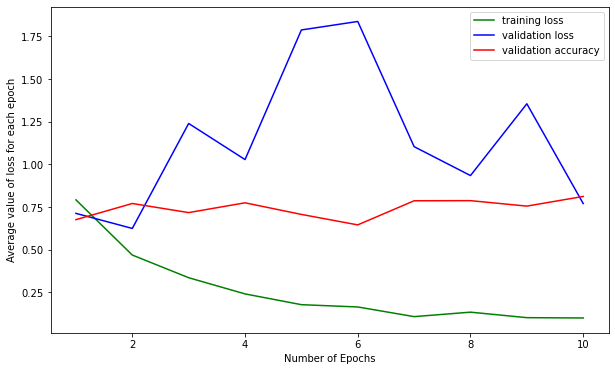

In [ ]:
from torch.optim import Adam
import torch.nn.functional as F
import matplotlib.pyplot as plt
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')


model_basic = Net()
model_basic.to(device)

optimizer = Adam(model_basic.parameters())
criterion = nn.CrossEntropyLoss()
save_path = f'cifar_net.pt'

TRAIN(model_basic, train_iter, valid_iter, 10, criterion, optimizer, device,save_path)

### Test Only Simplified model : Those are the fail cases, just for record purpose. We will use dataset imbalance handling to solve the accuracy problem.

In [ ]:
# which is randomly trial
class trial_model(nn.Module):
    def __init__(self):
        super(trial_model, self).__init__()
        self.conv1 = nn.Conv2d(1, 6, 5)
        self.pool = nn.MaxPool2d(2, 2)
        self.conv2 = nn.Conv2d(6, 16, 5)
        self.fc1 = nn.Linear(16 * 5 * 5, 120)
        self.fc2 = nn.Linear(120, 84)
        self.fc3 = nn.Linear(84, 10)

    def forward(self, x):
        x = self.pool(F.relu(self.conv1(x)))
        x = self.pool(F.relu(self.conv2(x)))
        x = x.view(-1, 16 * 5 * 5)
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = self.fc3(x)
        return x


Epoch [1/10], Training Loss: 2.1775, Validation Loss: 2.0605, Validation Accuracy: 0.3333
Model saved to cifar_net.pt



Epoch [2/10], Training Loss: 1.9406, Validation Loss: 1.8021, Validation Accuracy: 0.4333
Model saved to cifar_net.pt



Epoch [3/10], Training Loss: 1.5101, Validation Loss: 1.2379, Validation Accuracy: 0.4507
Model saved to cifar_net.pt



Epoch [4/10], Training Loss: 1.1140, Validation Loss: 1.1124, Validation Accuracy: 0.3193



Epoch [5/10], Training Loss: 1.0290, Validation Loss: 1.0188, Validation Accuracy: 0.5873
Model saved to cifar_net.pt



Epoch [6/10], Training Loss: 0.9651, Validation Loss: 0.9748, Validation Accuracy: 0.6240
Model saved to cifar_net.pt



Epoch [7/10], Training Loss: 0.9220, Validation Loss: 0.9430, Validation Accuracy: 0.6247
Model saved to cifar_net.pt



Epoch [8/10], Training Loss: 0.9020, Validation Loss: 0.9207, Validation Accuracy: 0.6280
Model saved to cifar_net.pt



Epoch [9/10], Training Loss: 0.8891, Validation Loss: 0.8944, Validation Accuracy: 0.5807



Epoch [10/10], Training Loss: 0.8553, Validation Loss: 0.8726, Validation Accuracy: 0.6553
Model saved to cifar_net.pt
Finished Training
The best acuracy is: tensor(0.6553, device='cuda:0')


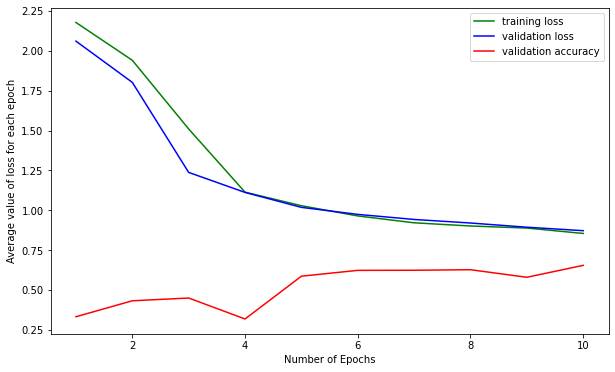

In [ ]:
# using the second model
from torch.optim import Adam
import torch.nn.functional as F
import matplotlib.pyplot as plt
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')


model_basic = trial_model()
model_basic.to(device)

optimizer = optim.SGD(model_basic.parameters(), lr=0.001, momentum=0.9)
criterion = nn.CrossEntropyLoss()
save_path = f'cifar_net.pt'

TRAIN(model_basic, train_iter, valid_iter, 10, criterion, optimizer, device,save_path)

In [ ]:
class Base_line(nn.Module):
    def __init__(self):
        super(Base_line, self).__init__()
        self.conv1 = nn.Conv2d(1, 8, 5)
        self.pool = nn.MaxPool2d(2, 2)
        self.conv2 = nn.Conv2d(8, 16, 5)
        self.fc1 = nn.Linear(16 * 5 * 5, 120)
        self.fc2 = nn.Linear(120, 84)
        self.fc3 = nn.Linear(84, 3)

    def forward(self, x):
        x = self.pool(F.relu(self.conv1(x)))
        x = self.pool(F.relu(self.conv2(x)))
        x = x.view(-1, 16 * 5 * 5)
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = self.fc3(x)
        return x


class Basic_Model(nn.Module):
    def __init__(self):
        super(Basic_Model, self).__init__()
        
        self.conv1 = nn.Conv2d(in_channels = 3, out_channels = 6, kernel_size = 5)  
        self.pool = nn.MaxPool2d(2, 2)
        self.norm1 = nn.BatchNorm2d(6) 
        self.conv2 = nn.Conv2d(in_channels=6, out_channels=16,  kernel_size=5)  
        self.norm2 = nn.BatchNorm2d(16) 
        self.fc1 = nn.Linear(16 * 5 * 5, 120)
        self.fc2 = nn.Linear(120, 84)
        self.fc3 = nn.Linear(84, 10)

    def forward(self, image): 
        image = self.norm1(self.pool(F.relu(self.conv1(image)))) #6, 14, 14 
        image = self.norm2(self.pool(F.relu(self.conv2(image)))) #16, 5, 5
        image = image.view(-1, 16 * 5 * 5)
        image = F.relu(self.fc1(image))
        image = F.relu(self.fc2(image))
        image = self.fc3(image)
        return image


Epoch [1/10], Training Loss: 1.0995, Validation Loss: 1.0983, Validation Accuracy: 0.3520
Model saved to layer_3_model.pt



Epoch [2/10], Training Loss: 1.0973, Validation Loss: 1.0963, Validation Accuracy: 0.4013
Model saved to layer_3_model.pt



Epoch [3/10], Training Loss: 1.0949, Validation Loss: 1.0936, Validation Accuracy: 0.4240
Model saved to layer_3_model.pt



Epoch [4/10], Training Loss: 1.0913, Validation Loss: 1.0891, Validation Accuracy: 0.4840
Model saved to layer_3_model.pt



Epoch [5/10], Training Loss: 1.0852, Validation Loss: 1.0816, Validation Accuracy: 0.5320
Model saved to layer_3_model.pt



Epoch [6/10], Training Loss: 1.0747, Validation Loss: 1.0687, Validation Accuracy: 0.5120



Epoch [7/10], Training Loss: 1.0568, Validation Loss: 1.0480, Validation Accuracy: 0.5173



Epoch [8/10], Training Loss: 1.0309, Validation Loss: 1.0264, Validation Accuracy: 0.5213



Epoch [9/10], Training Loss: 1.0033, Validation Loss: 1.0060, Validation Accuracy: 0.4947



Epoch [10/10], Training Loss: 0.9710, Validation Loss: 0.9798, Validation Accuracy: 0.4713
Finished Training
The best acuracy is: 0.532


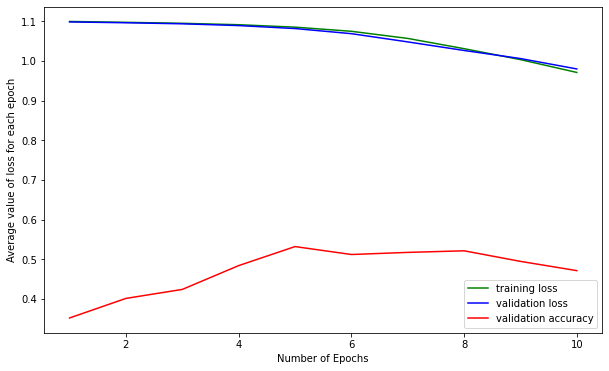

In [ ]:
# using the second model
from torch.optim import Adam
import torch.nn.functional as F
import matplotlib.pyplot as plt
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')


model_basic = Base_line()
model_basic.to(device)

optimizer = optim.SGD(model_basic.parameters(), lr=0.001, momentum=0.9)
criterion = nn.CrossEntropyLoss()
save_path = f'layer_3_model.pt'

TRAIN(model_basic, train_iter, valid_iter, 10, criterion, optimizer, device,save_path)


Epoch [1/10], Training Loss: 0.8389, Validation Loss: 0.6623, Validation Accuracy: 0.7400
Model saved to layer_3_model.pt



Epoch [2/10], Training Loss: 0.5551, Validation Loss: 0.6310, Validation Accuracy: 0.7800
Model saved to layer_3_model.pt



Epoch [3/10], Training Loss: 0.3987, Validation Loss: 0.7300, Validation Accuracy: 0.7667



Epoch [4/10], Training Loss: 0.3048, Validation Loss: 0.7445, Validation Accuracy: 0.7793



Epoch [5/10], Training Loss: 0.2557, Validation Loss: 0.8403, Validation Accuracy: 0.7913
Model saved to layer_3_model.pt



Epoch [6/10], Training Loss: 0.1988, Validation Loss: 0.7863, Validation Accuracy: 0.7800



Epoch [7/10], Training Loss: 0.1782, Validation Loss: 1.0373, Validation Accuracy: 0.7633



Epoch [8/10], Training Loss: 0.1355, Validation Loss: 1.0443, Validation Accuracy: 0.7540



Epoch [9/10], Training Loss: 0.1336, Validation Loss: 1.3270, Validation Accuracy: 0.7720



Epoch [10/10], Training Loss: 0.0973, Validation Loss: 1.2227, Validation Accuracy: 0.7600
Finished Training
The best acuracy is: 0.7913333


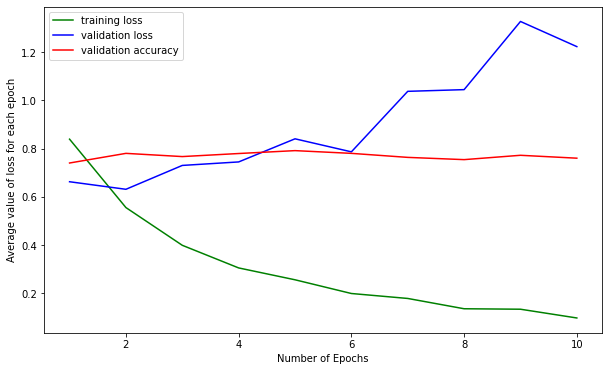

In [ ]:
# using the second model
from torch.optim import Adam
import torch.nn.functional as F
import matplotlib.pyplot as plt
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')


model_basic = trial_layer_3()
model_basic.to(device)

optimizer = Adam(model_basic.parameters())
criterion = nn.CrossEntropyLoss()
save_path = f'layer_3_model.pt'

TRAIN(model_basic, train_iter, valid_iter, 10, criterion, optimizer, device,save_path)

# After Solving the data imbalance, this is the improve dataset.

In [ ]:
# Some setup

from sklearn.model_selection import train_test_split
import torchvision.transforms as transforms
from torch.utils.data import DataLoader
from torch.utils.data import Dataset
from tqdm.notebook import tqdm
import torch.nn as nn
from PIL import Image
import numpy as np
import torch




with_mask = target_df[target_df.target == 0]
without_mask = target_df[target_df.target == 1]
incorrect_weared = target_df[target_df.target == 2]

with_mask_train, with_mask_valid = train_test_split(with_mask, test_size = 0.2, random_state = 4211)
without_mask_train, without_mask_valid = train_test_split(without_mask, test_size = 0.2, random_state = 4211)
incorrect_weared_train, incorrect_weared_valid = train_test_split(incorrect_weared, test_size = 0.2, random_state = 4211)

without_mask_train = without_mask_train.sample(len(with_mask_train), replace = True, random_state = 4211)
incorrect_weared_train = incorrect_weared_train.sample(len(with_mask_train), replace = True, random_state = 4211)

train_df = pd.concat([with_mask_train, without_mask_train, incorrect_weared_train], ignore_index=True)
valid_df = pd.concat([with_mask_valid, without_mask_valid, incorrect_weared_valid], ignore_index=True)


## Experiment 6 , Transform comparison on random_flip

### without random_flip

(tensor([[[-0.6627, -0.6627, -0.6627,  ..., -0.8353, -0.8353, -0.8353],
         [-0.6627, -0.6627, -0.6627,  ..., -0.8353, -0.8353, -0.8353],
         [-0.6392, -0.6392, -0.6392,  ..., -0.8353, -0.8353, -0.8353],
         ...,
         [-0.7961, -0.7961, -0.7961,  ..., -0.7882, -0.7882, -0.7882],
         [-0.8039, -0.8039, -0.8039,  ..., -0.7882, -0.7882, -0.7882],
         [-0.8039, -0.8039, -0.8039,  ..., -0.7882, -0.7882, -0.7882]]]), 0)



Epoch [1/15], Training Loss: 0.7680, Validation Loss: 0.5525, Validation Accuracy: 0.7672
Model saved to Transformlayer_3_model.pt



Epoch [2/15], Training Loss: 0.4490, Validation Loss: 0.5237, Validation Accuracy: 0.7855
Model saved to Transformlayer_3_model.pt



Epoch [3/15], Training Loss: 0.3206, Validation Loss: 0.5337, Validation Accuracy: 0.8064
Model saved to Transformlayer_3_model.pt



Epoch [4/15], Training Loss: 0.2386, Validation Loss: 0.4463, Validation Accuracy: 0.8419
Model saved to Transformlayer_3_model.pt



Epoch [5/15], Training Loss: 0.1836, Validation Loss: 0.3980, Validation Accuracy: 0.8652
Model saved to Transformlayer_3_model.pt



Epoch [6/15], Training Loss: 0.1585, Validation Loss: 0.4563, Validation Accuracy: 0.8505



Epoch [7/15], Training Loss: 0.1366, Validation Loss: 0.4005, Validation Accuracy: 0.8836
Model saved to Transformlayer_3_model.pt



Epoch [8/15], Training Loss: 0.1105, Validation Loss: 0.4578, Validation Accuracy: 0.8689



Epoch [9/15], Training Loss: 0.0953, Validation Loss: 0.4629, Validation Accuracy: 0.8873
Model saved to Transformlayer_3_model.pt



Epoch [10/15], Training Loss: 0.0809, Validation Loss: 0.5601, Validation Accuracy: 0.8517



Epoch [11/15], Training Loss: 0.0675, Validation Loss: 0.5039, Validation Accuracy: 0.8787



Epoch [12/15], Training Loss: 0.0597, Validation Loss: 0.4897, Validation Accuracy: 0.9007
Model saved to Transformlayer_3_model.pt



Epoch [13/15], Training Loss: 0.0530, Validation Loss: 0.5300, Validation Accuracy: 0.8824



Epoch [14/15], Training Loss: 0.0549, Validation Loss: 0.5484, Validation Accuracy: 0.8848



Epoch [15/15], Training Loss: 0.0422, Validation Loss: 0.6151, Validation Accuracy: 0.8775
Finished Training
The best acuracy is: 0.9007353


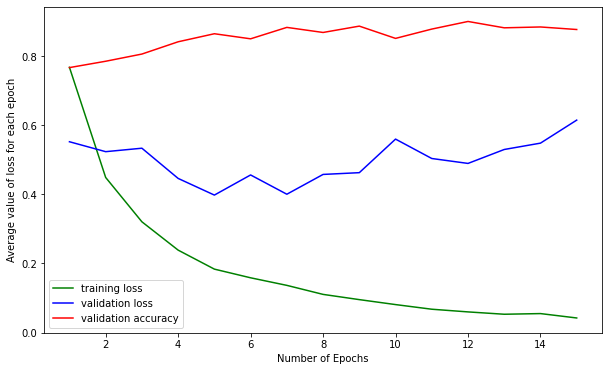

In [ ]:
from torch.utils.data import DataLoader
from torch.optim import Adam
import torch.nn.functional as F
import matplotlib.pyplot as plt
# define transform without using randomflip
transform = transforms.Compose([transforms.Resize((32, 32)), 
              transforms.Grayscale(1), transforms.ToTensor(), transforms.Normalize((0.5, ), (0.5, ))

              ])

train_set = FaceDataset(train_df, 'gdrive/MyDrive/images', transform = transform)
valid_set = FaceDataset(valid_df, 'gdrive/MyDrive/images', transform = transform)
train_iter = DataLoader(dataset = train_set, batch_size = 64, shuffle = True)
valid_iter = DataLoader(dataset = valid_set)
print(train_set[0])
dataiter = iter(train_iter)
images, labels = dataiter.next()
# base line model again : for easily reference.
class Base_line(nn.Module):
    def __init__(self):
        super(Base_line, self).__init__()
        self.conv1 = nn.Conv2d(1, 8, 5)
        self.pool = nn.MaxPool2d(2, 2)
        self.conv2 = nn.Conv2d(8, 16, 5)
        self.fc1 = nn.Linear(16 * 5 * 5, 120)
        self.fc2 = nn.Linear(120, 84)
        self.fc3 = nn.Linear(84, 3)

    def forward(self, x):
        x = self.pool(F.relu(self.conv1(x)))
        x = self.pool(F.relu(self.conv2(x)))
        x = x.view(-1, 16 * 5 * 5)
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = self.fc3(x)
        return x

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')


model_basic = Base_line()
model_basic.to(device)

optimizer = Adam(model_basic.parameters())
criterion = nn.CrossEntropyLoss()
save_path = f'Transformlayer_3_model.pt'

TRAIN(model_basic, train_iter, valid_iter, 15, criterion, optimizer, device,save_path)

###  Baseline model with Random horizontal flip in transfrom

In [ ]:
from torch.utils.data import DataLoader
#get all the training set and the validation set.
transform = transforms.Compose([transforms.Resize((32, 32)), 
              transforms.Grayscale(1), transforms.ToTensor(), transforms.Normalize((0.5, ), (0.5, )),
              transforms.RandomHorizontalFlip(p=0.5),
              ])

train_set = FaceDataset(train_df, 'gdrive/MyDrive/images', transform = transform)
valid_set = FaceDataset(valid_df, 'gdrive/MyDrive/images', transform = transform)

# put them into the dataloader:
train_iter = DataLoader(dataset = train_set, batch_size = 64, shuffle = True)
valid_iter = DataLoader(dataset = valid_set)



Epoch [1/15], Training Loss: 0.7495, Validation Loss: 0.5107, Validation Accuracy: 0.8113
Model saved to Transformlayer_model.pt



Epoch [2/15], Training Loss: 0.4696, Validation Loss: 0.4898, Validation Accuracy: 0.8039



Epoch [3/15], Training Loss: 0.3392, Validation Loss: 0.3871, Validation Accuracy: 0.8517
Model saved to Transformlayer_model.pt



Epoch [4/15], Training Loss: 0.2799, Validation Loss: 0.4608, Validation Accuracy: 0.8223



Epoch [5/15], Training Loss: 0.2232, Validation Loss: 0.4236, Validation Accuracy: 0.8493



Epoch [6/15], Training Loss: 0.1940, Validation Loss: 0.4247, Validation Accuracy: 0.8591
Model saved to Transformlayer_model.pt



Epoch [7/15], Training Loss: 0.1709, Validation Loss: 0.3821, Validation Accuracy: 0.8775
Model saved to Transformlayer_model.pt



Epoch [8/15], Training Loss: 0.1610, Validation Loss: 0.4132, Validation Accuracy: 0.8554



Epoch [9/15], Training Loss: 0.1514, Validation Loss: 0.3961, Validation Accuracy: 0.8676



Epoch [10/15], Training Loss: 0.1287, Validation Loss: 0.4072, Validation Accuracy: 0.8689



Epoch [11/15], Training Loss: 0.1286, Validation Loss: 0.4296, Validation Accuracy: 0.8775



Epoch [12/15], Training Loss: 0.1159, Validation Loss: 0.4092, Validation Accuracy: 0.8860
Model saved to Transformlayer_model.pt



Epoch [13/15], Training Loss: 0.0982, Validation Loss: 0.4355, Validation Accuracy: 0.8811



Epoch [14/15], Training Loss: 0.0959, Validation Loss: 0.5261, Validation Accuracy: 0.8603



Epoch [15/15], Training Loss: 0.0946, Validation Loss: 0.4225, Validation Accuracy: 0.8860
Finished Training
The best acuracy is: 0.8860294


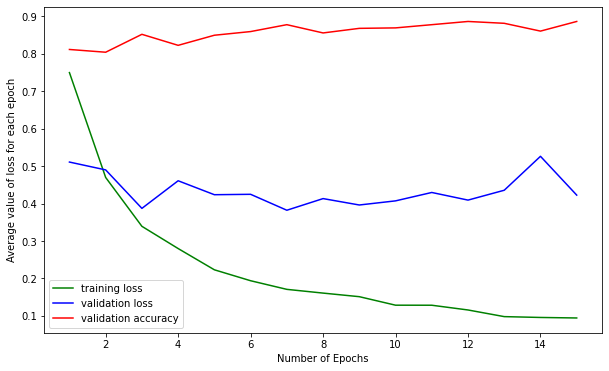

In [ ]:

from torch.optim import Adam
import torch.nn.functional as F
import matplotlib.pyplot as plt
import torch.nn as nn

class Base_line(nn.Module):
    def __init__(self):
        super(Base_line, self).__init__()
        self.conv1 = nn.Conv2d(1, 8, 5)
        self.pool = nn.MaxPool2d(2, 2)
        self.conv2 = nn.Conv2d(8, 16, 5)
        self.fc1 = nn.Linear(16 * 5 * 5, 120)
        self.fc2 = nn.Linear(120, 84)
        self.fc3 = nn.Linear(84, 3)

    def forward(self, x):
        x = self.pool(F.relu(self.conv1(x)))
        x = self.pool(F.relu(self.conv2(x)))
        x = x.view(-1, 16 * 5 * 5)
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = self.fc3(x)
        return x

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')


model = Base_line()
model.to(device)

optimizer = Adam(model.parameters())
criterion = nn.CrossEntropyLoss()
save_path = f'Transformlayer_model.pt'

TRAIN(model, train_iter, valid_iter, 15, criterion, optimizer, device,save_path)

## Experiment 7 Drop out layer added to the base line model


Epoch [1/15], Training Loss: 0.6666, Validation Loss: 0.5102, Validation Accuracy: 0.7978
Model saved to drop_model.pt



Epoch [2/15], Training Loss: 0.4013, Validation Loss: 0.4363, Validation Accuracy: 0.8199
Model saved to drop_model.pt



Epoch [3/15], Training Loss: 0.3210, Validation Loss: 0.3447, Validation Accuracy: 0.8640
Model saved to drop_model.pt



Epoch [4/15], Training Loss: 0.2779, Validation Loss: 0.3612, Validation Accuracy: 0.8615



Epoch [5/15], Training Loss: 0.2350, Validation Loss: 0.3951, Validation Accuracy: 0.8468



Epoch [6/15], Training Loss: 0.2107, Validation Loss: 0.4497, Validation Accuracy: 0.8370



Epoch [7/15], Training Loss: 0.1963, Validation Loss: 0.4061, Validation Accuracy: 0.8627



Epoch [8/15], Training Loss: 0.1888, Validation Loss: 0.3665, Validation Accuracy: 0.8640



Epoch [9/15], Training Loss: 0.1745, Validation Loss: 0.3108, Validation Accuracy: 0.8762
Model saved to drop_model.pt



Epoch [10/15], Training Loss: 0.1655, Validation Loss: 0.4082, Validation Accuracy: 0.8603



Epoch [11/15], Training Loss: 0.1516, Validation Loss: 0.3244, Validation Accuracy: 0.8836
Model saved to drop_model.pt



Epoch [12/15], Training Loss: 0.1327, Validation Loss: 0.3338, Validation Accuracy: 0.8946
Model saved to drop_model.pt



Epoch [13/15], Training Loss: 0.1395, Validation Loss: 0.3225, Validation Accuracy: 0.8848



Epoch [14/15], Training Loss: 0.1363, Validation Loss: 0.3874, Validation Accuracy: 0.8676



Epoch [15/15], Training Loss: 0.1368, Validation Loss: 0.3425, Validation Accuracy: 0.8909
Finished Training
The best acuracy is: 0.8946079


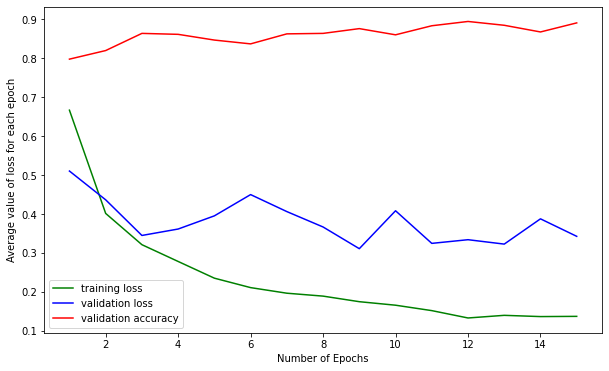

In [ ]:
from torch.optim import Adam
import torch.nn.functional as F
import matplotlib.pyplot as plt
class Drop_Model(nn.Module):
    def __init__(self):
        super(Drop_Model, self).__init__()
        
        self.conv1 = nn.Conv2d(in_channels = 1, out_channels = 8, kernel_size = 5)  
        self.pool = nn.MaxPool2d(2, 2)
        self.norm1 = nn.BatchNorm2d(8) 
        self.conv2 = nn.Conv2d(in_channels=8, out_channels=16,  kernel_size=5)  
        self.norm2 = nn.BatchNorm2d(16) 
        self.drop = nn.Dropout(0.5)
        self.fc1 = nn.Linear(16 * 5 * 5, 120)
        self.fc2 = nn.Linear(120, 84)
        self.fc3 = nn.Linear(84, 3)

    def forward(self, image): 
        image = self.norm1(self.pool(F.relu(self.conv1(image)))) #6, 14, 14 
        image = self.norm2(self.pool(F.relu(self.conv2(image)))) #16, 5, 5
        image = image.view(-1, 16 * 5 * 5)
        image = self.drop(image)
        image = F.relu(self.fc1(image))
        image = F.relu(self.fc2(image))
        image = self.fc3(image)
        return image

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')


model = Drop_Model()
model.to(device)

optimizer = Adam(model.parameters())
criterion = nn.CrossEntropyLoss()
save_path = f'drop_model.pt'

TRAIN(model, train_iter, valid_iter, 15, criterion, optimizer, device,save_path)

## Two dropout layers for testing Only. 


Epoch [1/15], Training Loss: 0.7326, Validation Loss: 0.9055, Validation Accuracy: 0.6520
Model saved to drop_model.pt



Epoch [2/15], Training Loss: 0.5226, Validation Loss: 0.9008, Validation Accuracy: 0.6324



Epoch [3/15], Training Loss: 0.4475, Validation Loss: 0.7151, Validation Accuracy: 0.7157
Model saved to drop_model.pt



Epoch [4/15], Training Loss: 0.4056, Validation Loss: 0.4916, Validation Accuracy: 0.8027
Model saved to drop_model.pt



Epoch [5/15], Training Loss: 0.3712, Validation Loss: 0.5926, Validation Accuracy: 0.7672



Epoch [6/15], Training Loss: 0.3403, Validation Loss: 0.5990, Validation Accuracy: 0.7561



Epoch [7/15], Training Loss: 0.3159, Validation Loss: 0.4601, Validation Accuracy: 0.8100
Model saved to drop_model.pt



Epoch [8/15], Training Loss: 0.3007, Validation Loss: 0.5018, Validation Accuracy: 0.8039



Epoch [9/15], Training Loss: 0.2782, Validation Loss: 0.5559, Validation Accuracy: 0.7721



Epoch [10/15], Training Loss: 0.2641, Validation Loss: 0.4478, Validation Accuracy: 0.8248
Model saved to drop_model.pt



Epoch [11/15], Training Loss: 0.2623, Validation Loss: 0.4209, Validation Accuracy: 0.8333
Model saved to drop_model.pt



Epoch [12/15], Training Loss: 0.2327, Validation Loss: 0.4225, Validation Accuracy: 0.8309



Epoch [13/15], Training Loss: 0.2344, Validation Loss: 0.4204, Validation Accuracy: 0.8456
Model saved to drop_model.pt



Epoch [14/15], Training Loss: 0.2154, Validation Loss: 0.4664, Validation Accuracy: 0.8174



Epoch [15/15], Training Loss: 0.2245, Validation Loss: 0.3837, Validation Accuracy: 0.8566
Model saved to drop_model.pt
Finished Training
The best acuracy is: 0.8566177


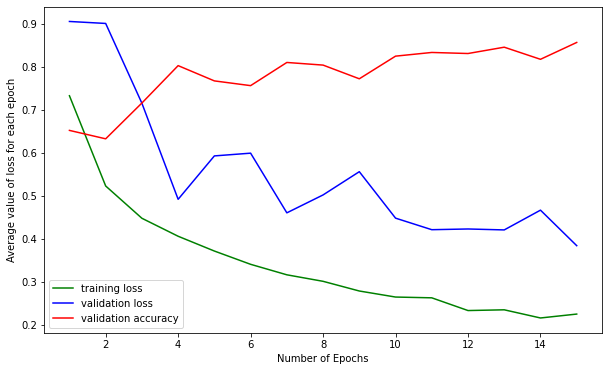

In [ ]:

from torch.optim import Adam
import torch.nn.functional as F
import matplotlib.pyplot as plt
class Double_Drop(nn.Module):
    def __init__(self):
        super(Double_Drop, self).__init__()
        
        self.conv1 = nn.Conv2d(in_channels = 1, out_channels = 8, kernel_size = 5)  
        self.pool = nn.MaxPool2d(2, 2)
        self.norm1 = nn.BatchNorm2d(8) 
        self.conv2 = nn.Conv2d(in_channels=8, out_channels=16,  kernel_size=5)  
        self.norm2 = nn.BatchNorm2d(16) 
        self.drop = nn.Dropout(0.5)
        self.fc1 = nn.Linear(16 * 5 * 5, 120)
        self.fc2 = nn.Linear(120, 84)
        self.fc3 = nn.Linear(84, 3)

    def forward(self, image): 
        image = self.norm1(self.pool(F.relu(self.conv1(image)))) #6, 14, 14 
        image = self.drop(image)
        image = self.norm2(self.pool(F.relu(self.conv2(image)))) #16, 5, 5
        image = image.view(-1, 16 * 5 * 5)
        image = self.drop(image)
        image = F.relu(self.fc1(image))
        image = F.relu(self.fc2(image))
        image = self.fc3(image)
        return image

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

model = Double_Drop()
model.to(device)

optimizer = Adam(model.parameters())
criterion = nn.CrossEntropyLoss()
save_path = f'drop_model.pt'

TRAIN(model, train_iter, valid_iter, 15, criterion, optimizer, device,save_path)

## Experiment 8 Three conv layer without dropout

torch.Size([64, 1, 32, 32])
torch.Size([64, 16, 6, 6])
torch.Size([64, 32, 2, 2])
torch.Size([64, 1, 32, 32])
torch.Size([64, 16, 6, 6])
torch.Size([64, 32, 2, 2])
torch.Size([64, 1, 32, 32])
torch.Size([64, 16, 6, 6])
torch.Size([64, 32, 2, 2])
torch.Size([64, 1, 32, 32])
torch.Size([64, 16, 6, 6])
torch.Size([64, 32, 2, 2])
torch.Size([64, 1, 32, 32])
torch.Size([64, 16, 6, 6])
torch.Size([64, 32, 2, 2])
torch.Size([64, 1, 32, 32])
torch.Size([64, 16, 6, 6])
torch.Size([64, 32, 2, 2])
torch.Size([64, 1, 32, 32])
torch.Size([64, 16, 6, 6])
torch.Size([64, 32, 2, 2])
torch.Size([64, 1, 32, 32])
torch.Size([64, 16, 6, 6])
torch.Size([64, 32, 2, 2])
torch.Size([64, 1, 32, 32])
torch.Size([64, 16, 6, 6])
torch.Size([64, 32, 2, 2])
torch.Size([64, 1, 32, 32])
torch.Size([64, 16, 6, 6])
torch.Size([64, 32, 2, 2])
torch.Size([64, 1, 32, 32])
torch.Size([64, 16, 6, 6])
torch.Size([64, 32, 2, 2])
torch.Size([64, 1, 32, 32])
torch.Size([64, 16, 6, 6])
torch.Size([64, 32, 2, 2])
torch.Size([64, 

torch.Size([1, 1, 32, 32])
torch.Size([1, 16, 6, 6])
torch.Size([1, 32, 2, 2])
torch.Size([1, 1, 32, 32])
torch.Size([1, 16, 6, 6])
torch.Size([1, 32, 2, 2])
torch.Size([1, 1, 32, 32])
torch.Size([1, 16, 6, 6])
torch.Size([1, 32, 2, 2])
torch.Size([1, 1, 32, 32])
torch.Size([1, 16, 6, 6])
torch.Size([1, 32, 2, 2])
torch.Size([1, 1, 32, 32])
torch.Size([1, 16, 6, 6])
torch.Size([1, 32, 2, 2])
torch.Size([1, 1, 32, 32])
torch.Size([1, 16, 6, 6])
torch.Size([1, 32, 2, 2])
torch.Size([1, 1, 32, 32])
torch.Size([1, 16, 6, 6])
torch.Size([1, 32, 2, 2])
torch.Size([1, 1, 32, 32])
torch.Size([1, 16, 6, 6])
torch.Size([1, 32, 2, 2])
torch.Size([1, 1, 32, 32])
torch.Size([1, 16, 6, 6])
torch.Size([1, 32, 2, 2])
torch.Size([1, 1, 32, 32])
torch.Size([1, 16, 6, 6])
torch.Size([1, 32, 2, 2])
torch.Size([1, 1, 32, 32])
torch.Size([1, 16, 6, 6])
torch.Size([1, 32, 2, 2])
torch.Size([1, 1, 32, 32])
torch.Size([1, 16, 6, 6])
torch.Size([1, 32, 2, 2])
torch.Size([1, 1, 32, 32])
torch.Size([1, 16, 6, 6])

torch.Size([64, 1, 32, 32])
torch.Size([64, 16, 6, 6])
torch.Size([64, 32, 2, 2])
torch.Size([64, 1, 32, 32])
torch.Size([64, 16, 6, 6])
torch.Size([64, 32, 2, 2])
torch.Size([64, 1, 32, 32])
torch.Size([64, 16, 6, 6])
torch.Size([64, 32, 2, 2])
torch.Size([64, 1, 32, 32])
torch.Size([64, 16, 6, 6])
torch.Size([64, 32, 2, 2])
torch.Size([64, 1, 32, 32])
torch.Size([64, 16, 6, 6])
torch.Size([64, 32, 2, 2])
torch.Size([64, 1, 32, 32])
torch.Size([64, 16, 6, 6])
torch.Size([64, 32, 2, 2])
torch.Size([64, 1, 32, 32])
torch.Size([64, 16, 6, 6])
torch.Size([64, 32, 2, 2])
torch.Size([64, 1, 32, 32])
torch.Size([64, 16, 6, 6])
torch.Size([64, 32, 2, 2])
torch.Size([64, 1, 32, 32])
torch.Size([64, 16, 6, 6])
torch.Size([64, 32, 2, 2])
torch.Size([64, 1, 32, 32])
torch.Size([64, 16, 6, 6])
torch.Size([64, 32, 2, 2])
torch.Size([64, 1, 32, 32])
torch.Size([64, 16, 6, 6])
torch.Size([64, 32, 2, 2])
torch.Size([64, 1, 32, 32])
torch.Size([64, 16, 6, 6])
torch.Size([64, 32, 2, 2])
torch.Size([64, 

torch.Size([1, 1, 32, 32])
torch.Size([1, 16, 6, 6])
torch.Size([1, 32, 2, 2])
torch.Size([1, 1, 32, 32])
torch.Size([1, 16, 6, 6])
torch.Size([1, 32, 2, 2])
torch.Size([1, 1, 32, 32])
torch.Size([1, 16, 6, 6])
torch.Size([1, 32, 2, 2])
torch.Size([1, 1, 32, 32])
torch.Size([1, 16, 6, 6])
torch.Size([1, 32, 2, 2])
torch.Size([1, 1, 32, 32])
torch.Size([1, 16, 6, 6])
torch.Size([1, 32, 2, 2])
torch.Size([1, 1, 32, 32])
torch.Size([1, 16, 6, 6])
torch.Size([1, 32, 2, 2])
torch.Size([1, 1, 32, 32])
torch.Size([1, 16, 6, 6])
torch.Size([1, 32, 2, 2])
torch.Size([1, 1, 32, 32])
torch.Size([1, 16, 6, 6])
torch.Size([1, 32, 2, 2])
torch.Size([1, 1, 32, 32])
torch.Size([1, 16, 6, 6])
torch.Size([1, 32, 2, 2])
torch.Size([1, 1, 32, 32])
torch.Size([1, 16, 6, 6])
torch.Size([1, 32, 2, 2])
torch.Size([1, 1, 32, 32])
torch.Size([1, 16, 6, 6])
torch.Size([1, 32, 2, 2])
torch.Size([1, 1, 32, 32])
torch.Size([1, 16, 6, 6])
torch.Size([1, 32, 2, 2])
torch.Size([1, 1, 32, 32])
torch.Size([1, 16, 6, 6])

torch.Size([64, 1, 32, 32])
torch.Size([64, 16, 6, 6])
torch.Size([64, 32, 2, 2])
torch.Size([64, 1, 32, 32])
torch.Size([64, 16, 6, 6])
torch.Size([64, 32, 2, 2])
torch.Size([64, 1, 32, 32])
torch.Size([64, 16, 6, 6])
torch.Size([64, 32, 2, 2])
torch.Size([64, 1, 32, 32])
torch.Size([64, 16, 6, 6])
torch.Size([64, 32, 2, 2])
torch.Size([64, 1, 32, 32])
torch.Size([64, 16, 6, 6])
torch.Size([64, 32, 2, 2])
torch.Size([64, 1, 32, 32])
torch.Size([64, 16, 6, 6])
torch.Size([64, 32, 2, 2])
torch.Size([64, 1, 32, 32])
torch.Size([64, 16, 6, 6])
torch.Size([64, 32, 2, 2])
torch.Size([64, 1, 32, 32])
torch.Size([64, 16, 6, 6])
torch.Size([64, 32, 2, 2])
torch.Size([64, 1, 32, 32])
torch.Size([64, 16, 6, 6])
torch.Size([64, 32, 2, 2])
torch.Size([64, 1, 32, 32])
torch.Size([64, 16, 6, 6])
torch.Size([64, 32, 2, 2])
torch.Size([64, 1, 32, 32])
torch.Size([64, 16, 6, 6])
torch.Size([64, 32, 2, 2])
torch.Size([64, 1, 32, 32])
torch.Size([64, 16, 6, 6])
torch.Size([64, 32, 2, 2])
torch.Size([64, 

torch.Size([1, 1, 32, 32])
torch.Size([1, 16, 6, 6])
torch.Size([1, 32, 2, 2])
torch.Size([1, 1, 32, 32])
torch.Size([1, 16, 6, 6])
torch.Size([1, 32, 2, 2])
torch.Size([1, 1, 32, 32])
torch.Size([1, 16, 6, 6])
torch.Size([1, 32, 2, 2])
torch.Size([1, 1, 32, 32])
torch.Size([1, 16, 6, 6])
torch.Size([1, 32, 2, 2])
torch.Size([1, 1, 32, 32])
torch.Size([1, 16, 6, 6])
torch.Size([1, 32, 2, 2])
torch.Size([1, 1, 32, 32])
torch.Size([1, 16, 6, 6])
torch.Size([1, 32, 2, 2])
torch.Size([1, 1, 32, 32])
torch.Size([1, 16, 6, 6])
torch.Size([1, 32, 2, 2])
torch.Size([1, 1, 32, 32])
torch.Size([1, 16, 6, 6])
torch.Size([1, 32, 2, 2])
torch.Size([1, 1, 32, 32])
torch.Size([1, 16, 6, 6])
torch.Size([1, 32, 2, 2])
torch.Size([1, 1, 32, 32])
torch.Size([1, 16, 6, 6])
torch.Size([1, 32, 2, 2])
torch.Size([1, 1, 32, 32])
torch.Size([1, 16, 6, 6])
torch.Size([1, 32, 2, 2])
torch.Size([1, 1, 32, 32])
torch.Size([1, 16, 6, 6])
torch.Size([1, 32, 2, 2])
torch.Size([1, 1, 32, 32])
torch.Size([1, 16, 6, 6])

torch.Size([64, 1, 32, 32])
torch.Size([64, 16, 6, 6])
torch.Size([64, 32, 2, 2])
torch.Size([64, 1, 32, 32])
torch.Size([64, 16, 6, 6])
torch.Size([64, 32, 2, 2])
torch.Size([64, 1, 32, 32])
torch.Size([64, 16, 6, 6])
torch.Size([64, 32, 2, 2])
torch.Size([64, 1, 32, 32])
torch.Size([64, 16, 6, 6])
torch.Size([64, 32, 2, 2])
torch.Size([64, 1, 32, 32])
torch.Size([64, 16, 6, 6])
torch.Size([64, 32, 2, 2])
torch.Size([64, 1, 32, 32])
torch.Size([64, 16, 6, 6])
torch.Size([64, 32, 2, 2])
torch.Size([64, 1, 32, 32])
torch.Size([64, 16, 6, 6])
torch.Size([64, 32, 2, 2])
torch.Size([64, 1, 32, 32])
torch.Size([64, 16, 6, 6])
torch.Size([64, 32, 2, 2])
torch.Size([64, 1, 32, 32])
torch.Size([64, 16, 6, 6])
torch.Size([64, 32, 2, 2])
torch.Size([64, 1, 32, 32])
torch.Size([64, 16, 6, 6])
torch.Size([64, 32, 2, 2])
torch.Size([64, 1, 32, 32])
torch.Size([64, 16, 6, 6])
torch.Size([64, 32, 2, 2])
torch.Size([64, 1, 32, 32])
torch.Size([64, 16, 6, 6])
torch.Size([64, 32, 2, 2])
torch.Size([64, 

torch.Size([1, 1, 32, 32])
torch.Size([1, 16, 6, 6])
torch.Size([1, 32, 2, 2])
torch.Size([1, 1, 32, 32])
torch.Size([1, 16, 6, 6])
torch.Size([1, 32, 2, 2])
torch.Size([1, 1, 32, 32])
torch.Size([1, 16, 6, 6])
torch.Size([1, 32, 2, 2])
torch.Size([1, 1, 32, 32])
torch.Size([1, 16, 6, 6])
torch.Size([1, 32, 2, 2])
torch.Size([1, 1, 32, 32])
torch.Size([1, 16, 6, 6])
torch.Size([1, 32, 2, 2])
torch.Size([1, 1, 32, 32])
torch.Size([1, 16, 6, 6])
torch.Size([1, 32, 2, 2])
torch.Size([1, 1, 32, 32])
torch.Size([1, 16, 6, 6])
torch.Size([1, 32, 2, 2])
torch.Size([1, 1, 32, 32])
torch.Size([1, 16, 6, 6])
torch.Size([1, 32, 2, 2])
torch.Size([1, 1, 32, 32])
torch.Size([1, 16, 6, 6])
torch.Size([1, 32, 2, 2])
torch.Size([1, 1, 32, 32])
torch.Size([1, 16, 6, 6])
torch.Size([1, 32, 2, 2])
torch.Size([1, 1, 32, 32])
torch.Size([1, 16, 6, 6])
torch.Size([1, 32, 2, 2])
torch.Size([1, 1, 32, 32])
torch.Size([1, 16, 6, 6])
torch.Size([1, 32, 2, 2])
torch.Size([1, 1, 32, 32])
torch.Size([1, 16, 6, 6])

torch.Size([64, 1, 32, 32])
torch.Size([64, 16, 6, 6])
torch.Size([64, 32, 2, 2])
torch.Size([64, 1, 32, 32])
torch.Size([64, 16, 6, 6])
torch.Size([64, 32, 2, 2])
torch.Size([64, 1, 32, 32])
torch.Size([64, 16, 6, 6])
torch.Size([64, 32, 2, 2])
torch.Size([64, 1, 32, 32])
torch.Size([64, 16, 6, 6])
torch.Size([64, 32, 2, 2])
torch.Size([64, 1, 32, 32])
torch.Size([64, 16, 6, 6])
torch.Size([64, 32, 2, 2])
torch.Size([64, 1, 32, 32])
torch.Size([64, 16, 6, 6])
torch.Size([64, 32, 2, 2])
torch.Size([64, 1, 32, 32])
torch.Size([64, 16, 6, 6])
torch.Size([64, 32, 2, 2])
torch.Size([64, 1, 32, 32])
torch.Size([64, 16, 6, 6])
torch.Size([64, 32, 2, 2])
torch.Size([64, 1, 32, 32])
torch.Size([64, 16, 6, 6])
torch.Size([64, 32, 2, 2])
torch.Size([64, 1, 32, 32])
torch.Size([64, 16, 6, 6])
torch.Size([64, 32, 2, 2])
torch.Size([64, 1, 32, 32])
torch.Size([64, 16, 6, 6])
torch.Size([64, 32, 2, 2])
torch.Size([64, 1, 32, 32])
torch.Size([64, 16, 6, 6])
torch.Size([64, 32, 2, 2])
torch.Size([64, 

torch.Size([1, 1, 32, 32])
torch.Size([1, 16, 6, 6])
torch.Size([1, 32, 2, 2])
torch.Size([1, 1, 32, 32])
torch.Size([1, 16, 6, 6])
torch.Size([1, 32, 2, 2])
torch.Size([1, 1, 32, 32])
torch.Size([1, 16, 6, 6])
torch.Size([1, 32, 2, 2])
torch.Size([1, 1, 32, 32])
torch.Size([1, 16, 6, 6])
torch.Size([1, 32, 2, 2])
torch.Size([1, 1, 32, 32])
torch.Size([1, 16, 6, 6])
torch.Size([1, 32, 2, 2])
torch.Size([1, 1, 32, 32])
torch.Size([1, 16, 6, 6])
torch.Size([1, 32, 2, 2])
torch.Size([1, 1, 32, 32])
torch.Size([1, 16, 6, 6])
torch.Size([1, 32, 2, 2])
torch.Size([1, 1, 32, 32])
torch.Size([1, 16, 6, 6])
torch.Size([1, 32, 2, 2])
torch.Size([1, 1, 32, 32])
torch.Size([1, 16, 6, 6])
torch.Size([1, 32, 2, 2])
torch.Size([1, 1, 32, 32])
torch.Size([1, 16, 6, 6])
torch.Size([1, 32, 2, 2])
torch.Size([1, 1, 32, 32])
torch.Size([1, 16, 6, 6])
torch.Size([1, 32, 2, 2])
torch.Size([1, 1, 32, 32])
torch.Size([1, 16, 6, 6])
torch.Size([1, 32, 2, 2])
torch.Size([1, 1, 32, 32])
torch.Size([1, 16, 6, 6])

torch.Size([64, 1, 32, 32])
torch.Size([64, 16, 6, 6])
torch.Size([64, 32, 2, 2])
torch.Size([64, 1, 32, 32])
torch.Size([64, 16, 6, 6])
torch.Size([64, 32, 2, 2])
torch.Size([64, 1, 32, 32])
torch.Size([64, 16, 6, 6])
torch.Size([64, 32, 2, 2])
torch.Size([64, 1, 32, 32])
torch.Size([64, 16, 6, 6])
torch.Size([64, 32, 2, 2])
torch.Size([64, 1, 32, 32])
torch.Size([64, 16, 6, 6])
torch.Size([64, 32, 2, 2])
torch.Size([64, 1, 32, 32])
torch.Size([64, 16, 6, 6])
torch.Size([64, 32, 2, 2])
torch.Size([64, 1, 32, 32])
torch.Size([64, 16, 6, 6])
torch.Size([64, 32, 2, 2])
torch.Size([64, 1, 32, 32])
torch.Size([64, 16, 6, 6])
torch.Size([64, 32, 2, 2])
torch.Size([64, 1, 32, 32])
torch.Size([64, 16, 6, 6])
torch.Size([64, 32, 2, 2])
torch.Size([64, 1, 32, 32])
torch.Size([64, 16, 6, 6])
torch.Size([64, 32, 2, 2])
torch.Size([64, 1, 32, 32])
torch.Size([64, 16, 6, 6])
torch.Size([64, 32, 2, 2])
torch.Size([64, 1, 32, 32])
torch.Size([64, 16, 6, 6])
torch.Size([64, 32, 2, 2])
torch.Size([64, 

torch.Size([1, 1, 32, 32])
torch.Size([1, 16, 6, 6])
torch.Size([1, 32, 2, 2])
torch.Size([1, 1, 32, 32])
torch.Size([1, 16, 6, 6])
torch.Size([1, 32, 2, 2])
torch.Size([1, 1, 32, 32])
torch.Size([1, 16, 6, 6])
torch.Size([1, 32, 2, 2])
torch.Size([1, 1, 32, 32])
torch.Size([1, 16, 6, 6])
torch.Size([1, 32, 2, 2])
torch.Size([1, 1, 32, 32])
torch.Size([1, 16, 6, 6])
torch.Size([1, 32, 2, 2])
torch.Size([1, 1, 32, 32])
torch.Size([1, 16, 6, 6])
torch.Size([1, 32, 2, 2])
torch.Size([1, 1, 32, 32])
torch.Size([1, 16, 6, 6])
torch.Size([1, 32, 2, 2])
torch.Size([1, 1, 32, 32])
torch.Size([1, 16, 6, 6])
torch.Size([1, 32, 2, 2])
torch.Size([1, 1, 32, 32])
torch.Size([1, 16, 6, 6])
torch.Size([1, 32, 2, 2])
torch.Size([1, 1, 32, 32])
torch.Size([1, 16, 6, 6])
torch.Size([1, 32, 2, 2])
torch.Size([1, 1, 32, 32])
torch.Size([1, 16, 6, 6])
torch.Size([1, 32, 2, 2])
torch.Size([1, 1, 32, 32])
torch.Size([1, 16, 6, 6])
torch.Size([1, 32, 2, 2])
torch.Size([1, 1, 32, 32])
torch.Size([1, 16, 6, 6])

torch.Size([64, 1, 32, 32])
torch.Size([64, 16, 6, 6])
torch.Size([64, 32, 2, 2])
torch.Size([64, 1, 32, 32])
torch.Size([64, 16, 6, 6])
torch.Size([64, 32, 2, 2])
torch.Size([64, 1, 32, 32])
torch.Size([64, 16, 6, 6])
torch.Size([64, 32, 2, 2])
torch.Size([64, 1, 32, 32])
torch.Size([64, 16, 6, 6])
torch.Size([64, 32, 2, 2])
torch.Size([64, 1, 32, 32])
torch.Size([64, 16, 6, 6])
torch.Size([64, 32, 2, 2])
torch.Size([64, 1, 32, 32])
torch.Size([64, 16, 6, 6])
torch.Size([64, 32, 2, 2])
torch.Size([64, 1, 32, 32])
torch.Size([64, 16, 6, 6])
torch.Size([64, 32, 2, 2])
torch.Size([64, 1, 32, 32])
torch.Size([64, 16, 6, 6])
torch.Size([64, 32, 2, 2])
torch.Size([64, 1, 32, 32])
torch.Size([64, 16, 6, 6])
torch.Size([64, 32, 2, 2])
torch.Size([64, 1, 32, 32])
torch.Size([64, 16, 6, 6])
torch.Size([64, 32, 2, 2])
torch.Size([64, 1, 32, 32])
torch.Size([64, 16, 6, 6])
torch.Size([64, 32, 2, 2])
torch.Size([64, 1, 32, 32])
torch.Size([64, 16, 6, 6])
torch.Size([64, 32, 2, 2])
torch.Size([64, 

torch.Size([1, 1, 32, 32])
torch.Size([1, 16, 6, 6])
torch.Size([1, 32, 2, 2])
torch.Size([1, 1, 32, 32])
torch.Size([1, 16, 6, 6])
torch.Size([1, 32, 2, 2])
torch.Size([1, 1, 32, 32])
torch.Size([1, 16, 6, 6])
torch.Size([1, 32, 2, 2])
torch.Size([1, 1, 32, 32])
torch.Size([1, 16, 6, 6])
torch.Size([1, 32, 2, 2])
torch.Size([1, 1, 32, 32])
torch.Size([1, 16, 6, 6])
torch.Size([1, 32, 2, 2])
torch.Size([1, 1, 32, 32])
torch.Size([1, 16, 6, 6])
torch.Size([1, 32, 2, 2])
torch.Size([1, 1, 32, 32])
torch.Size([1, 16, 6, 6])
torch.Size([1, 32, 2, 2])
torch.Size([1, 1, 32, 32])
torch.Size([1, 16, 6, 6])
torch.Size([1, 32, 2, 2])
torch.Size([1, 1, 32, 32])
torch.Size([1, 16, 6, 6])
torch.Size([1, 32, 2, 2])
torch.Size([1, 1, 32, 32])
torch.Size([1, 16, 6, 6])
torch.Size([1, 32, 2, 2])
torch.Size([1, 1, 32, 32])
torch.Size([1, 16, 6, 6])
torch.Size([1, 32, 2, 2])
torch.Size([1, 1, 32, 32])
torch.Size([1, 16, 6, 6])
torch.Size([1, 32, 2, 2])
torch.Size([1, 1, 32, 32])
torch.Size([1, 16, 6, 6])

torch.Size([64, 1, 32, 32])
torch.Size([64, 16, 6, 6])
torch.Size([64, 32, 2, 2])
torch.Size([64, 1, 32, 32])
torch.Size([64, 16, 6, 6])
torch.Size([64, 32, 2, 2])
torch.Size([64, 1, 32, 32])
torch.Size([64, 16, 6, 6])
torch.Size([64, 32, 2, 2])
torch.Size([64, 1, 32, 32])
torch.Size([64, 16, 6, 6])
torch.Size([64, 32, 2, 2])
torch.Size([64, 1, 32, 32])
torch.Size([64, 16, 6, 6])
torch.Size([64, 32, 2, 2])
torch.Size([64, 1, 32, 32])
torch.Size([64, 16, 6, 6])
torch.Size([64, 32, 2, 2])
torch.Size([64, 1, 32, 32])
torch.Size([64, 16, 6, 6])
torch.Size([64, 32, 2, 2])
torch.Size([64, 1, 32, 32])
torch.Size([64, 16, 6, 6])
torch.Size([64, 32, 2, 2])
torch.Size([64, 1, 32, 32])
torch.Size([64, 16, 6, 6])
torch.Size([64, 32, 2, 2])
torch.Size([64, 1, 32, 32])
torch.Size([64, 16, 6, 6])
torch.Size([64, 32, 2, 2])
torch.Size([64, 1, 32, 32])
torch.Size([64, 16, 6, 6])
torch.Size([64, 32, 2, 2])
torch.Size([64, 1, 32, 32])
torch.Size([64, 16, 6, 6])
torch.Size([64, 32, 2, 2])
torch.Size([64, 

torch.Size([1, 1, 32, 32])
torch.Size([1, 16, 6, 6])
torch.Size([1, 32, 2, 2])
torch.Size([1, 1, 32, 32])
torch.Size([1, 16, 6, 6])
torch.Size([1, 32, 2, 2])
torch.Size([1, 1, 32, 32])
torch.Size([1, 16, 6, 6])
torch.Size([1, 32, 2, 2])
torch.Size([1, 1, 32, 32])
torch.Size([1, 16, 6, 6])
torch.Size([1, 32, 2, 2])
torch.Size([1, 1, 32, 32])
torch.Size([1, 16, 6, 6])
torch.Size([1, 32, 2, 2])
torch.Size([1, 1, 32, 32])
torch.Size([1, 16, 6, 6])
torch.Size([1, 32, 2, 2])
torch.Size([1, 1, 32, 32])
torch.Size([1, 16, 6, 6])
torch.Size([1, 32, 2, 2])
torch.Size([1, 1, 32, 32])
torch.Size([1, 16, 6, 6])
torch.Size([1, 32, 2, 2])
torch.Size([1, 1, 32, 32])
torch.Size([1, 16, 6, 6])
torch.Size([1, 32, 2, 2])
torch.Size([1, 1, 32, 32])
torch.Size([1, 16, 6, 6])
torch.Size([1, 32, 2, 2])
torch.Size([1, 1, 32, 32])
torch.Size([1, 16, 6, 6])
torch.Size([1, 32, 2, 2])
torch.Size([1, 1, 32, 32])
torch.Size([1, 16, 6, 6])
torch.Size([1, 32, 2, 2])
torch.Size([1, 1, 32, 32])
torch.Size([1, 16, 6, 6])

torch.Size([64, 1, 32, 32])
torch.Size([64, 16, 6, 6])
torch.Size([64, 32, 2, 2])
torch.Size([64, 1, 32, 32])
torch.Size([64, 16, 6, 6])
torch.Size([64, 32, 2, 2])
torch.Size([64, 1, 32, 32])
torch.Size([64, 16, 6, 6])
torch.Size([64, 32, 2, 2])
torch.Size([64, 1, 32, 32])
torch.Size([64, 16, 6, 6])
torch.Size([64, 32, 2, 2])
torch.Size([64, 1, 32, 32])
torch.Size([64, 16, 6, 6])
torch.Size([64, 32, 2, 2])
torch.Size([64, 1, 32, 32])
torch.Size([64, 16, 6, 6])
torch.Size([64, 32, 2, 2])
torch.Size([64, 1, 32, 32])
torch.Size([64, 16, 6, 6])
torch.Size([64, 32, 2, 2])
torch.Size([64, 1, 32, 32])
torch.Size([64, 16, 6, 6])
torch.Size([64, 32, 2, 2])
torch.Size([64, 1, 32, 32])
torch.Size([64, 16, 6, 6])
torch.Size([64, 32, 2, 2])
torch.Size([64, 1, 32, 32])
torch.Size([64, 16, 6, 6])
torch.Size([64, 32, 2, 2])
torch.Size([64, 1, 32, 32])
torch.Size([64, 16, 6, 6])
torch.Size([64, 32, 2, 2])
torch.Size([64, 1, 32, 32])
torch.Size([64, 16, 6, 6])
torch.Size([64, 32, 2, 2])
torch.Size([64, 

torch.Size([1, 1, 32, 32])
torch.Size([1, 16, 6, 6])
torch.Size([1, 32, 2, 2])
torch.Size([1, 1, 32, 32])
torch.Size([1, 16, 6, 6])
torch.Size([1, 32, 2, 2])
torch.Size([1, 1, 32, 32])
torch.Size([1, 16, 6, 6])
torch.Size([1, 32, 2, 2])
torch.Size([1, 1, 32, 32])
torch.Size([1, 16, 6, 6])
torch.Size([1, 32, 2, 2])
torch.Size([1, 1, 32, 32])
torch.Size([1, 16, 6, 6])
torch.Size([1, 32, 2, 2])
torch.Size([1, 1, 32, 32])
torch.Size([1, 16, 6, 6])
torch.Size([1, 32, 2, 2])
torch.Size([1, 1, 32, 32])
torch.Size([1, 16, 6, 6])
torch.Size([1, 32, 2, 2])
torch.Size([1, 1, 32, 32])
torch.Size([1, 16, 6, 6])
torch.Size([1, 32, 2, 2])
torch.Size([1, 1, 32, 32])
torch.Size([1, 16, 6, 6])
torch.Size([1, 32, 2, 2])
torch.Size([1, 1, 32, 32])
torch.Size([1, 16, 6, 6])
torch.Size([1, 32, 2, 2])
torch.Size([1, 1, 32, 32])
torch.Size([1, 16, 6, 6])
torch.Size([1, 32, 2, 2])
torch.Size([1, 1, 32, 32])
torch.Size([1, 16, 6, 6])
torch.Size([1, 32, 2, 2])
torch.Size([1, 1, 32, 32])
torch.Size([1, 16, 6, 6])

torch.Size([64, 1, 32, 32])
torch.Size([64, 16, 6, 6])
torch.Size([64, 32, 2, 2])
torch.Size([64, 1, 32, 32])
torch.Size([64, 16, 6, 6])
torch.Size([64, 32, 2, 2])
torch.Size([64, 1, 32, 32])
torch.Size([64, 16, 6, 6])
torch.Size([64, 32, 2, 2])
torch.Size([64, 1, 32, 32])
torch.Size([64, 16, 6, 6])
torch.Size([64, 32, 2, 2])
torch.Size([64, 1, 32, 32])
torch.Size([64, 16, 6, 6])
torch.Size([64, 32, 2, 2])
torch.Size([64, 1, 32, 32])
torch.Size([64, 16, 6, 6])
torch.Size([64, 32, 2, 2])
torch.Size([64, 1, 32, 32])
torch.Size([64, 16, 6, 6])
torch.Size([64, 32, 2, 2])
torch.Size([64, 1, 32, 32])
torch.Size([64, 16, 6, 6])
torch.Size([64, 32, 2, 2])
torch.Size([64, 1, 32, 32])
torch.Size([64, 16, 6, 6])
torch.Size([64, 32, 2, 2])
torch.Size([64, 1, 32, 32])
torch.Size([64, 16, 6, 6])
torch.Size([64, 32, 2, 2])
torch.Size([64, 1, 32, 32])
torch.Size([64, 16, 6, 6])
torch.Size([64, 32, 2, 2])
torch.Size([64, 1, 32, 32])
torch.Size([64, 16, 6, 6])
torch.Size([64, 32, 2, 2])
torch.Size([64, 

torch.Size([1, 1, 32, 32])
torch.Size([1, 16, 6, 6])
torch.Size([1, 32, 2, 2])
torch.Size([1, 1, 32, 32])
torch.Size([1, 16, 6, 6])
torch.Size([1, 32, 2, 2])
torch.Size([1, 1, 32, 32])
torch.Size([1, 16, 6, 6])
torch.Size([1, 32, 2, 2])
torch.Size([1, 1, 32, 32])
torch.Size([1, 16, 6, 6])
torch.Size([1, 32, 2, 2])
torch.Size([1, 1, 32, 32])
torch.Size([1, 16, 6, 6])
torch.Size([1, 32, 2, 2])
torch.Size([1, 1, 32, 32])
torch.Size([1, 16, 6, 6])
torch.Size([1, 32, 2, 2])
torch.Size([1, 1, 32, 32])
torch.Size([1, 16, 6, 6])
torch.Size([1, 32, 2, 2])
torch.Size([1, 1, 32, 32])
torch.Size([1, 16, 6, 6])
torch.Size([1, 32, 2, 2])
torch.Size([1, 1, 32, 32])
torch.Size([1, 16, 6, 6])
torch.Size([1, 32, 2, 2])
torch.Size([1, 1, 32, 32])
torch.Size([1, 16, 6, 6])
torch.Size([1, 32, 2, 2])
torch.Size([1, 1, 32, 32])
torch.Size([1, 16, 6, 6])
torch.Size([1, 32, 2, 2])
torch.Size([1, 1, 32, 32])
torch.Size([1, 16, 6, 6])
torch.Size([1, 32, 2, 2])
torch.Size([1, 1, 32, 32])
torch.Size([1, 16, 6, 6])

torch.Size([64, 1, 32, 32])
torch.Size([64, 16, 6, 6])
torch.Size([64, 32, 2, 2])
torch.Size([64, 1, 32, 32])
torch.Size([64, 16, 6, 6])
torch.Size([64, 32, 2, 2])
torch.Size([64, 1, 32, 32])
torch.Size([64, 16, 6, 6])
torch.Size([64, 32, 2, 2])
torch.Size([64, 1, 32, 32])
torch.Size([64, 16, 6, 6])
torch.Size([64, 32, 2, 2])
torch.Size([64, 1, 32, 32])
torch.Size([64, 16, 6, 6])
torch.Size([64, 32, 2, 2])
torch.Size([64, 1, 32, 32])
torch.Size([64, 16, 6, 6])
torch.Size([64, 32, 2, 2])
torch.Size([64, 1, 32, 32])
torch.Size([64, 16, 6, 6])
torch.Size([64, 32, 2, 2])
torch.Size([64, 1, 32, 32])
torch.Size([64, 16, 6, 6])
torch.Size([64, 32, 2, 2])
torch.Size([64, 1, 32, 32])
torch.Size([64, 16, 6, 6])
torch.Size([64, 32, 2, 2])
torch.Size([64, 1, 32, 32])
torch.Size([64, 16, 6, 6])
torch.Size([64, 32, 2, 2])
torch.Size([64, 1, 32, 32])
torch.Size([64, 16, 6, 6])
torch.Size([64, 32, 2, 2])
torch.Size([64, 1, 32, 32])
torch.Size([64, 16, 6, 6])
torch.Size([64, 32, 2, 2])
torch.Size([64, 

torch.Size([1, 1, 32, 32])
torch.Size([1, 16, 6, 6])
torch.Size([1, 32, 2, 2])
torch.Size([1, 1, 32, 32])
torch.Size([1, 16, 6, 6])
torch.Size([1, 32, 2, 2])
torch.Size([1, 1, 32, 32])
torch.Size([1, 16, 6, 6])
torch.Size([1, 32, 2, 2])
torch.Size([1, 1, 32, 32])
torch.Size([1, 16, 6, 6])
torch.Size([1, 32, 2, 2])
torch.Size([1, 1, 32, 32])
torch.Size([1, 16, 6, 6])
torch.Size([1, 32, 2, 2])
torch.Size([1, 1, 32, 32])
torch.Size([1, 16, 6, 6])
torch.Size([1, 32, 2, 2])
torch.Size([1, 1, 32, 32])
torch.Size([1, 16, 6, 6])
torch.Size([1, 32, 2, 2])
torch.Size([1, 1, 32, 32])
torch.Size([1, 16, 6, 6])
torch.Size([1, 32, 2, 2])
torch.Size([1, 1, 32, 32])
torch.Size([1, 16, 6, 6])
torch.Size([1, 32, 2, 2])
torch.Size([1, 1, 32, 32])
torch.Size([1, 16, 6, 6])
torch.Size([1, 32, 2, 2])
torch.Size([1, 1, 32, 32])
torch.Size([1, 16, 6, 6])
torch.Size([1, 32, 2, 2])
torch.Size([1, 1, 32, 32])
torch.Size([1, 16, 6, 6])
torch.Size([1, 32, 2, 2])
torch.Size([1, 1, 32, 32])
torch.Size([1, 16, 6, 6])

torch.Size([64, 1, 32, 32])
torch.Size([64, 16, 6, 6])
torch.Size([64, 32, 2, 2])
torch.Size([64, 1, 32, 32])
torch.Size([64, 16, 6, 6])
torch.Size([64, 32, 2, 2])
torch.Size([64, 1, 32, 32])
torch.Size([64, 16, 6, 6])
torch.Size([64, 32, 2, 2])
torch.Size([64, 1, 32, 32])
torch.Size([64, 16, 6, 6])
torch.Size([64, 32, 2, 2])
torch.Size([64, 1, 32, 32])
torch.Size([64, 16, 6, 6])
torch.Size([64, 32, 2, 2])
torch.Size([64, 1, 32, 32])
torch.Size([64, 16, 6, 6])
torch.Size([64, 32, 2, 2])
torch.Size([64, 1, 32, 32])
torch.Size([64, 16, 6, 6])
torch.Size([64, 32, 2, 2])
torch.Size([64, 1, 32, 32])
torch.Size([64, 16, 6, 6])
torch.Size([64, 32, 2, 2])
torch.Size([64, 1, 32, 32])
torch.Size([64, 16, 6, 6])
torch.Size([64, 32, 2, 2])
torch.Size([64, 1, 32, 32])
torch.Size([64, 16, 6, 6])
torch.Size([64, 32, 2, 2])
torch.Size([64, 1, 32, 32])
torch.Size([64, 16, 6, 6])
torch.Size([64, 32, 2, 2])
torch.Size([64, 1, 32, 32])
torch.Size([64, 16, 6, 6])
torch.Size([64, 32, 2, 2])
torch.Size([64, 

torch.Size([1, 1, 32, 32])
torch.Size([1, 16, 6, 6])
torch.Size([1, 32, 2, 2])
torch.Size([1, 1, 32, 32])
torch.Size([1, 16, 6, 6])
torch.Size([1, 32, 2, 2])
torch.Size([1, 1, 32, 32])
torch.Size([1, 16, 6, 6])
torch.Size([1, 32, 2, 2])
torch.Size([1, 1, 32, 32])
torch.Size([1, 16, 6, 6])
torch.Size([1, 32, 2, 2])
torch.Size([1, 1, 32, 32])
torch.Size([1, 16, 6, 6])
torch.Size([1, 32, 2, 2])
torch.Size([1, 1, 32, 32])
torch.Size([1, 16, 6, 6])
torch.Size([1, 32, 2, 2])
torch.Size([1, 1, 32, 32])
torch.Size([1, 16, 6, 6])
torch.Size([1, 32, 2, 2])
torch.Size([1, 1, 32, 32])
torch.Size([1, 16, 6, 6])
torch.Size([1, 32, 2, 2])
torch.Size([1, 1, 32, 32])
torch.Size([1, 16, 6, 6])
torch.Size([1, 32, 2, 2])
torch.Size([1, 1, 32, 32])
torch.Size([1, 16, 6, 6])
torch.Size([1, 32, 2, 2])
torch.Size([1, 1, 32, 32])
torch.Size([1, 16, 6, 6])
torch.Size([1, 32, 2, 2])
torch.Size([1, 1, 32, 32])
torch.Size([1, 16, 6, 6])
torch.Size([1, 32, 2, 2])
torch.Size([1, 1, 32, 32])
torch.Size([1, 16, 6, 6])

torch.Size([64, 1, 32, 32])
torch.Size([64, 16, 6, 6])
torch.Size([64, 32, 2, 2])
torch.Size([64, 1, 32, 32])
torch.Size([64, 16, 6, 6])
torch.Size([64, 32, 2, 2])
torch.Size([64, 1, 32, 32])
torch.Size([64, 16, 6, 6])
torch.Size([64, 32, 2, 2])
torch.Size([64, 1, 32, 32])
torch.Size([64, 16, 6, 6])
torch.Size([64, 32, 2, 2])
torch.Size([64, 1, 32, 32])
torch.Size([64, 16, 6, 6])
torch.Size([64, 32, 2, 2])
torch.Size([64, 1, 32, 32])
torch.Size([64, 16, 6, 6])
torch.Size([64, 32, 2, 2])
torch.Size([64, 1, 32, 32])
torch.Size([64, 16, 6, 6])
torch.Size([64, 32, 2, 2])
torch.Size([64, 1, 32, 32])
torch.Size([64, 16, 6, 6])
torch.Size([64, 32, 2, 2])
torch.Size([64, 1, 32, 32])
torch.Size([64, 16, 6, 6])
torch.Size([64, 32, 2, 2])
torch.Size([64, 1, 32, 32])
torch.Size([64, 16, 6, 6])
torch.Size([64, 32, 2, 2])
torch.Size([64, 1, 32, 32])
torch.Size([64, 16, 6, 6])
torch.Size([64, 32, 2, 2])
torch.Size([64, 1, 32, 32])
torch.Size([64, 16, 6, 6])
torch.Size([64, 32, 2, 2])
torch.Size([64, 

torch.Size([1, 1, 32, 32])
torch.Size([1, 16, 6, 6])
torch.Size([1, 32, 2, 2])
torch.Size([1, 1, 32, 32])
torch.Size([1, 16, 6, 6])
torch.Size([1, 32, 2, 2])
torch.Size([1, 1, 32, 32])
torch.Size([1, 16, 6, 6])
torch.Size([1, 32, 2, 2])
torch.Size([1, 1, 32, 32])
torch.Size([1, 16, 6, 6])
torch.Size([1, 32, 2, 2])
torch.Size([1, 1, 32, 32])
torch.Size([1, 16, 6, 6])
torch.Size([1, 32, 2, 2])
torch.Size([1, 1, 32, 32])
torch.Size([1, 16, 6, 6])
torch.Size([1, 32, 2, 2])
torch.Size([1, 1, 32, 32])
torch.Size([1, 16, 6, 6])
torch.Size([1, 32, 2, 2])
torch.Size([1, 1, 32, 32])
torch.Size([1, 16, 6, 6])
torch.Size([1, 32, 2, 2])
torch.Size([1, 1, 32, 32])
torch.Size([1, 16, 6, 6])
torch.Size([1, 32, 2, 2])
torch.Size([1, 1, 32, 32])
torch.Size([1, 16, 6, 6])
torch.Size([1, 32, 2, 2])
torch.Size([1, 1, 32, 32])
torch.Size([1, 16, 6, 6])
torch.Size([1, 32, 2, 2])
torch.Size([1, 1, 32, 32])
torch.Size([1, 16, 6, 6])
torch.Size([1, 32, 2, 2])
torch.Size([1, 1, 32, 32])
torch.Size([1, 16, 6, 6])

torch.Size([64, 1, 32, 32])
torch.Size([64, 16, 6, 6])
torch.Size([64, 32, 2, 2])
torch.Size([64, 1, 32, 32])
torch.Size([64, 16, 6, 6])
torch.Size([64, 32, 2, 2])
torch.Size([64, 1, 32, 32])
torch.Size([64, 16, 6, 6])
torch.Size([64, 32, 2, 2])
torch.Size([64, 1, 32, 32])
torch.Size([64, 16, 6, 6])
torch.Size([64, 32, 2, 2])
torch.Size([64, 1, 32, 32])
torch.Size([64, 16, 6, 6])
torch.Size([64, 32, 2, 2])
torch.Size([64, 1, 32, 32])
torch.Size([64, 16, 6, 6])
torch.Size([64, 32, 2, 2])
torch.Size([64, 1, 32, 32])
torch.Size([64, 16, 6, 6])
torch.Size([64, 32, 2, 2])
torch.Size([64, 1, 32, 32])
torch.Size([64, 16, 6, 6])
torch.Size([64, 32, 2, 2])
torch.Size([64, 1, 32, 32])
torch.Size([64, 16, 6, 6])
torch.Size([64, 32, 2, 2])
torch.Size([64, 1, 32, 32])
torch.Size([64, 16, 6, 6])
torch.Size([64, 32, 2, 2])
torch.Size([64, 1, 32, 32])
torch.Size([64, 16, 6, 6])
torch.Size([64, 32, 2, 2])
torch.Size([64, 1, 32, 32])
torch.Size([64, 16, 6, 6])
torch.Size([64, 32, 2, 2])
torch.Size([64, 

torch.Size([1, 1, 32, 32])
torch.Size([1, 16, 6, 6])
torch.Size([1, 32, 2, 2])
torch.Size([1, 1, 32, 32])
torch.Size([1, 16, 6, 6])
torch.Size([1, 32, 2, 2])
torch.Size([1, 1, 32, 32])
torch.Size([1, 16, 6, 6])
torch.Size([1, 32, 2, 2])
torch.Size([1, 1, 32, 32])
torch.Size([1, 16, 6, 6])
torch.Size([1, 32, 2, 2])
torch.Size([1, 1, 32, 32])
torch.Size([1, 16, 6, 6])
torch.Size([1, 32, 2, 2])
torch.Size([1, 1, 32, 32])
torch.Size([1, 16, 6, 6])
torch.Size([1, 32, 2, 2])
torch.Size([1, 1, 32, 32])
torch.Size([1, 16, 6, 6])
torch.Size([1, 32, 2, 2])
torch.Size([1, 1, 32, 32])
torch.Size([1, 16, 6, 6])
torch.Size([1, 32, 2, 2])
torch.Size([1, 1, 32, 32])
torch.Size([1, 16, 6, 6])
torch.Size([1, 32, 2, 2])
torch.Size([1, 1, 32, 32])
torch.Size([1, 16, 6, 6])
torch.Size([1, 32, 2, 2])
torch.Size([1, 1, 32, 32])
torch.Size([1, 16, 6, 6])
torch.Size([1, 32, 2, 2])
torch.Size([1, 1, 32, 32])
torch.Size([1, 16, 6, 6])
torch.Size([1, 32, 2, 2])
torch.Size([1, 1, 32, 32])
torch.Size([1, 16, 6, 6])

torch.Size([64, 1, 32, 32])
torch.Size([64, 16, 6, 6])
torch.Size([64, 32, 2, 2])
torch.Size([64, 1, 32, 32])
torch.Size([64, 16, 6, 6])
torch.Size([64, 32, 2, 2])
torch.Size([64, 1, 32, 32])
torch.Size([64, 16, 6, 6])
torch.Size([64, 32, 2, 2])
torch.Size([64, 1, 32, 32])
torch.Size([64, 16, 6, 6])
torch.Size([64, 32, 2, 2])
torch.Size([64, 1, 32, 32])
torch.Size([64, 16, 6, 6])
torch.Size([64, 32, 2, 2])
torch.Size([64, 1, 32, 32])
torch.Size([64, 16, 6, 6])
torch.Size([64, 32, 2, 2])
torch.Size([64, 1, 32, 32])
torch.Size([64, 16, 6, 6])
torch.Size([64, 32, 2, 2])
torch.Size([64, 1, 32, 32])
torch.Size([64, 16, 6, 6])
torch.Size([64, 32, 2, 2])
torch.Size([64, 1, 32, 32])
torch.Size([64, 16, 6, 6])
torch.Size([64, 32, 2, 2])
torch.Size([64, 1, 32, 32])
torch.Size([64, 16, 6, 6])
torch.Size([64, 32, 2, 2])
torch.Size([64, 1, 32, 32])
torch.Size([64, 16, 6, 6])
torch.Size([64, 32, 2, 2])
torch.Size([64, 1, 32, 32])
torch.Size([64, 16, 6, 6])
torch.Size([64, 32, 2, 2])
torch.Size([64, 

torch.Size([1, 1, 32, 32])
torch.Size([1, 16, 6, 6])
torch.Size([1, 32, 2, 2])
torch.Size([1, 1, 32, 32])
torch.Size([1, 16, 6, 6])
torch.Size([1, 32, 2, 2])
torch.Size([1, 1, 32, 32])
torch.Size([1, 16, 6, 6])
torch.Size([1, 32, 2, 2])
torch.Size([1, 1, 32, 32])
torch.Size([1, 16, 6, 6])
torch.Size([1, 32, 2, 2])
torch.Size([1, 1, 32, 32])
torch.Size([1, 16, 6, 6])
torch.Size([1, 32, 2, 2])
torch.Size([1, 1, 32, 32])
torch.Size([1, 16, 6, 6])
torch.Size([1, 32, 2, 2])
torch.Size([1, 1, 32, 32])
torch.Size([1, 16, 6, 6])
torch.Size([1, 32, 2, 2])
torch.Size([1, 1, 32, 32])
torch.Size([1, 16, 6, 6])
torch.Size([1, 32, 2, 2])
torch.Size([1, 1, 32, 32])
torch.Size([1, 16, 6, 6])
torch.Size([1, 32, 2, 2])
torch.Size([1, 1, 32, 32])
torch.Size([1, 16, 6, 6])
torch.Size([1, 32, 2, 2])
torch.Size([1, 1, 32, 32])
torch.Size([1, 16, 6, 6])
torch.Size([1, 32, 2, 2])
torch.Size([1, 1, 32, 32])
torch.Size([1, 16, 6, 6])
torch.Size([1, 32, 2, 2])
torch.Size([1, 1, 32, 32])
torch.Size([1, 16, 6, 6])

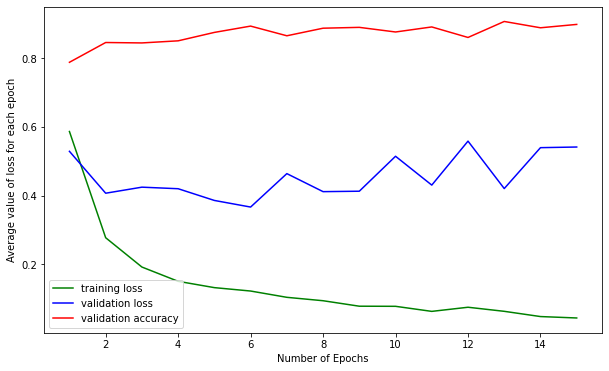

In [ ]:
from torch.optim import Adam
import torch.nn.functional as F
import matplotlib.pyplot as plt
class Three_layer_model(nn.Module):
    def __init__(self):
        super(Three_layer_model, self).__init__()
        
        self.conv1 = nn.Conv2d(in_channels = 1, out_channels = 8, kernel_size = 5)  #28
        self.pool = nn.MaxPool2d(2,2)#14
        self.norm1 = nn.BatchNorm2d(8) 
        self.conv2 = nn.Conv2d(in_channels=8, out_channels=16,  kernel_size=3) #12 #6
        self.norm2 = nn.BatchNorm2d(16) 
        self.conv3 = nn.Conv2d(in_channels=16, out_channels=32,  kernel_size=3)  #4 #2
        self.norm3 = nn.BatchNorm2d(32) 
        self.fc1 = nn.Linear(32*2*2, 120)
        self.fc2 = nn.Linear(120, 84)
        self.fc3 = nn.Linear(84, 3)

    def forward(self, image): 
        image = self.norm1(self.pool(F.relu(self.conv1(image)))) #6, 14, 14 
        image = self.norm2(self.pool(F.relu(self.conv2(image)))) #16, 5, 5
        image = self.norm3(self.pool(F.relu(self.conv3(image))))
        image = image.view(-1, 32 * 2 * 2)
        image = F.relu(self.fc1(image))
        image = F.relu(self.fc2(image))
        image = self.fc3(image)
        return image

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

model = Three_layer_model()
model.to(device)

optimizer = Adam(model.parameters())
criterion = nn.CrossEntropyLoss()
save_path = f'Three_layer_model.pt'

TRAIN(model, train_iter, valid_iter, 15, criterion, optimizer, device,save_path)

##Testing purpose Three conv layer with four fully connected layer, without dropout


Epoch [1/15], Training Loss: 0.5703, Validation Loss: 0.3833, Validation Accuracy: 0.8542
Model saved to Four_linear_layer.pt



Epoch [2/15], Training Loss: 0.2614, Validation Loss: 0.4386, Validation Accuracy: 0.8480



Epoch [3/15], Training Loss: 0.1858, Validation Loss: 0.3806, Validation Accuracy: 0.8627
Model saved to Four_linear_layer.pt



Epoch [4/15], Training Loss: 0.1323, Validation Loss: 0.3940, Validation Accuracy: 0.8873
Model saved to Four_linear_layer.pt



Epoch [5/15], Training Loss: 0.1107, Validation Loss: 0.4002, Validation Accuracy: 0.8848



Epoch [6/15], Training Loss: 0.1020, Validation Loss: 0.3729, Validation Accuracy: 0.8873



Epoch [7/15], Training Loss: 0.0903, Validation Loss: 0.4170, Validation Accuracy: 0.9044
Model saved to Four_linear_layer.pt



Epoch [8/15], Training Loss: 0.0760, Validation Loss: 0.4841, Validation Accuracy: 0.8775



Epoch [9/15], Training Loss: 0.0748, Validation Loss: 0.4722, Validation Accuracy: 0.8836



Epoch [10/15], Training Loss: 0.0821, Validation Loss: 0.5216, Validation Accuracy: 0.8873



Epoch [11/15], Training Loss: 0.0739, Validation Loss: 0.5001, Validation Accuracy: 0.8713



Epoch [12/15], Training Loss: 0.0525, Validation Loss: 0.4798, Validation Accuracy: 0.8958



Epoch [13/15], Training Loss: 0.0427, Validation Loss: 0.6360, Validation Accuracy: 0.8824



Epoch [14/15], Training Loss: 0.0837, Validation Loss: 0.4790, Validation Accuracy: 0.8971



Epoch [15/15], Training Loss: 0.0565, Validation Loss: 0.5305, Validation Accuracy: 0.8836
Finished Training
The best acuracy is: 0.9044118


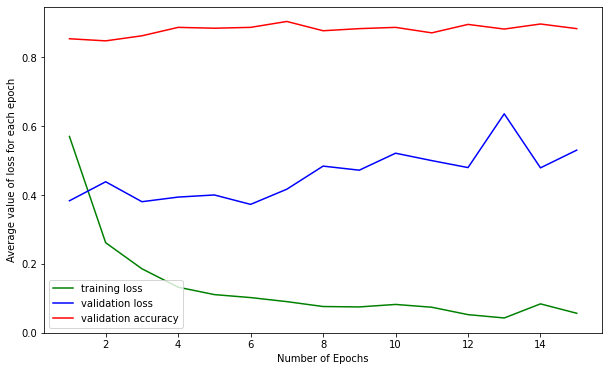

In [ ]:
from torch.optim import Adam
import torch.nn.functional as F
import matplotlib.pyplot as plt
class Four_layer_model(nn.Module):
    def __init__(self):
        super(Four_layer_model, self).__init__()
        
        self.conv1 = nn.Conv2d(in_channels = 1, out_channels = 8, kernel_size = 5)  #28
        self.pool = nn.MaxPool2d(2,2)#14
        self.norm1 = nn.BatchNorm2d(8) 
        self.conv2 = nn.Conv2d(in_channels=8, out_channels=16,  kernel_size=3) #12 #6
        self.norm2 = nn.BatchNorm2d(16) 
        self.conv3 = nn.Conv2d(in_channels=16, out_channels=32,  kernel_size=3)  #4 #2
        self.norm3 = nn.BatchNorm2d(32) 
        self.drop = nn.Dropout(0.5)
        self.fc1 = nn.Linear(32*2*2, 120)
        self.fc2 = nn.Linear(120, 84)
        self.fc3 = nn.Linear(84,48)
        self.fc4 = nn.Linear(48, 3)

    def forward(self, image): 
        image = self.norm1(self.pool(F.relu(self.conv1(image)))) #6, 14, 14 
        image = self.norm2(self.pool(F.relu(self.conv2(image)))) #16, 5, 5
        image = self.norm3(self.pool(F.relu(self.conv3(image))))
        image = image.view(-1, 32 * 2 * 2)
        image = F.relu(self.fc1(image))
        image = F.relu(self.fc2(image))
        image = F.relu(self.fc3(image))
        image = self.fc4(image) 
        return image

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = Four_layer_model()
model.to(device)
optimizer = Adam(model.parameters())
criterion = nn.CrossEntropyLoss()
save_path = f'Four_linear_layer.pt'

TRAIN(model, train_iter, valid_iter, 15, criterion, optimizer, device,save_path)

## Experiment 9 Comparing four fully connected layer with three conv layers. + 1 fc layer vs + 1 conv layer. (result of conv layer shown in experiment 8) 


Epoch [1/15], Training Loss: 0.5716, Validation Loss: 0.4787, Validation Accuracy: 0.8076
Model saved to doubleConv_dliner_model.pt



Epoch [2/15], Training Loss: 0.2552, Validation Loss: 0.4217, Validation Accuracy: 0.8517
Model saved to doubleConv_dliner_model.pt



Epoch [3/15], Training Loss: 0.1758, Validation Loss: 0.4701, Validation Accuracy: 0.8480



Epoch [4/15], Training Loss: 0.1325, Validation Loss: 0.3866, Validation Accuracy: 0.8848
Model saved to doubleConv_dliner_model.pt



Epoch [5/15], Training Loss: 0.1063, Validation Loss: 0.5259, Validation Accuracy: 0.8468



Epoch [6/15], Training Loss: 0.1042, Validation Loss: 0.4251, Validation Accuracy: 0.8725



Epoch [7/15], Training Loss: 0.0839, Validation Loss: 0.4003, Validation Accuracy: 0.8811



Epoch [8/15], Training Loss: 0.0665, Validation Loss: 0.4432, Validation Accuracy: 0.8885
Model saved to doubleConv_dliner_model.pt



Epoch [9/15], Training Loss: 0.0704, Validation Loss: 0.4236, Validation Accuracy: 0.8971
Model saved to doubleConv_dliner_model.pt



Epoch [10/15], Training Loss: 0.0637, Validation Loss: 0.6180, Validation Accuracy: 0.8652



Epoch [11/15], Training Loss: 0.0512, Validation Loss: 0.5055, Validation Accuracy: 0.8836



Epoch [12/15], Training Loss: 0.0486, Validation Loss: 0.4980, Validation Accuracy: 0.8934



Epoch [13/15], Training Loss: 0.0467, Validation Loss: 0.4512, Validation Accuracy: 0.9032
Model saved to doubleConv_dliner_model.pt



Epoch [14/15], Training Loss: 0.0465, Validation Loss: 0.4725, Validation Accuracy: 0.9105
Model saved to doubleConv_dliner_model.pt



Epoch [15/15], Training Loss: 0.0366, Validation Loss: 0.5414, Validation Accuracy: 0.8971
Finished Training
The best acuracy is: 0.91053927


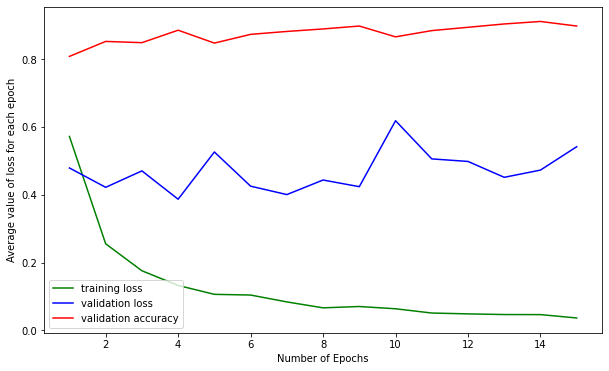

In [ ]:
# with double conv, four linear layer
class doubleConv_dliner(nn.Module):
    def __init__(self):
        super(doubleConv_dliner, self).__init__()
        
        self.conv1 = nn.Conv2d(in_channels = 1, out_channels = 8, kernel_size = 5)  
        self.pool = nn.MaxPool2d(2, 2)
        self.norm1 = nn.BatchNorm2d(8) 
        self.conv2 = nn.Conv2d(in_channels=8, out_channels=16,  kernel_size=5)  
        self.norm2 = nn.BatchNorm2d(16) 
        self.fc1 = nn.Linear(16 * 5 * 5, 120)
        self.fc2 = nn.Linear(120, 96)
        self.fc3 = nn.Linear(96, 84)
        self.fc4 = nn.Linear(84, 3)

    def forward(self, image): 
        image = self.norm1(self.pool(F.relu(self.conv1(image)))) #6, 14, 14 
        image = self.norm2(self.pool(F.relu(self.conv2(image)))) #16, 5, 5
        image = image.view(-1, 16 * 5 * 5)

        image = F.relu(self.fc1(image))
        image = F.relu(self.fc2(image))
        image = F.relu(self.fc3(image))
        image = self.fc4(image)
        return image
from torch.optim import Adam
import torch.nn.functional as F
import matplotlib.pyplot as plt
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')


model = doubleConv_dliner()
model.to(device)

optimizer = Adam(model.parameters())
criterion = nn.CrossEntropyLoss()
save_path = f'doubleConv_dliner_model.pt'

TRAIN(model, train_iter, valid_iter, 15, criterion, optimizer, device,save_path)


Epoch [1/15], Training Loss: 0.5913, Validation Loss: 0.3894, Validation Accuracy: 0.8431
Model saved to Model_modified_linear.pt



Epoch [2/15], Training Loss: 0.2535, Validation Loss: 0.4507, Validation Accuracy: 0.8309



Epoch [3/15], Training Loss: 0.1903, Validation Loss: 0.3349, Validation Accuracy: 0.8738
Model saved to Model_modified_linear.pt



Epoch [4/15], Training Loss: 0.1455, Validation Loss: 0.3564, Validation Accuracy: 0.8836
Model saved to Model_modified_linear.pt



Epoch [5/15], Training Loss: 0.1153, Validation Loss: 0.4236, Validation Accuracy: 0.8738



Epoch [6/15], Training Loss: 0.1054, Validation Loss: 0.4258, Validation Accuracy: 0.8860
Model saved to Model_modified_linear.pt



Epoch [7/15], Training Loss: 0.1003, Validation Loss: 0.3912, Validation Accuracy: 0.8860



Epoch [8/15], Training Loss: 0.0750, Validation Loss: 0.3846, Validation Accuracy: 0.8971
Model saved to Model_modified_linear.pt



Epoch [9/15], Training Loss: 0.0595, Validation Loss: 0.4522, Validation Accuracy: 0.8934



Epoch [10/15], Training Loss: 0.0501, Validation Loss: 0.4509, Validation Accuracy: 0.8909



Epoch [11/15], Training Loss: 0.0520, Validation Loss: 0.4319, Validation Accuracy: 0.8946



Epoch [12/15], Training Loss: 0.0727, Validation Loss: 0.3824, Validation Accuracy: 0.8848



Epoch [13/15], Training Loss: 0.0429, Validation Loss: 0.4760, Validation Accuracy: 0.9032
Model saved to Model_modified_linear.pt



Epoch [14/15], Training Loss: 0.0281, Validation Loss: 0.5045, Validation Accuracy: 0.8922



Epoch [15/15], Training Loss: 0.0274, Validation Loss: 0.6224, Validation Accuracy: 0.8971
Finished Training
The best acuracy is: 0.9031863


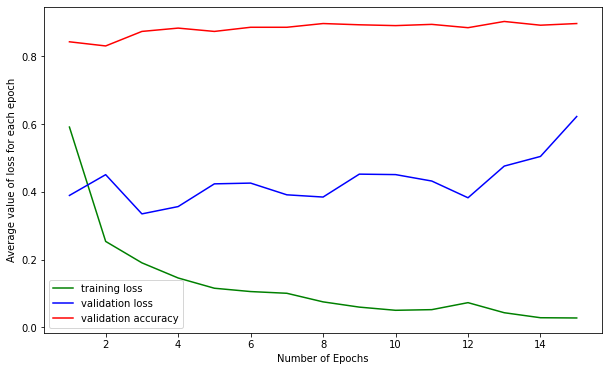

In [ ]:
# using the second model
class Model_modified_linear(nn.Module):
    def __init__(self):
        super(Model_modified_linear, self).__init__()
        
        self.conv1 = nn.Conv2d(in_channels = 1, out_channels = 8, kernel_size = 5)  
        self.pool = nn.MaxPool2d(2, 2)
        self.norm1 = nn.BatchNorm2d(8) 
        self.conv2 = nn.Conv2d(in_channels=8, out_channels=16,  kernel_size=5)  
        self.norm2 = nn.BatchNorm2d(16) 
        self.fc1 = nn.Linear(16 * 5 * 5, 120)
        self.fc2 = nn.Linear(120, 96)
        self.fc3 = nn.Linear(96, 84)
        self.fc4 = nn.Linear(84, 48)
        self.fc5 = nn.Linear(48, 3)

    def forward(self, image): 
        image = self.norm1(self.pool(F.relu(self.conv1(image)))) #6, 14, 14 
        image = self.norm2(self.pool(F.relu(self.conv2(image)))) #16, 5, 5
        image = image.view(-1, 16 * 5 * 5)

        image = F.relu(self.fc1(image))
        image = F.relu(self.fc2(image))
        image = F.relu(self.fc3(image))
        image = F.relu(self.fc4(image))
        image = self.fc5(image)
        return image
from torch.optim import Adam
import torch.nn.functional as F
import matplotlib.pyplot as plt
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')


model = Model_modified_linear()
model.to(device)
optimizer = Adam(model.parameters())
criterion = nn.CrossEntropyLoss()
save_path = f'Model_modified_linear.pt'

TRAIN(model_basic, train_iter, valid_iter, 15, criterion, optimizer, device,save_path)

## Not used in the report. Testing only. Average Pooling instead of using the Max pooling in the second conv layer


Epoch [1/15], Training Loss: 0.5515, Validation Loss: 0.4258, Validation Accuracy: 0.8199
Model saved to AveragePool_Model.pt



Epoch [2/15], Training Loss: 0.2571, Validation Loss: 0.3818, Validation Accuracy: 0.8578
Model saved to AveragePool_Model.pt



Epoch [3/15], Training Loss: 0.1803, Validation Loss: 0.3925, Validation Accuracy: 0.8578



Epoch [4/15], Training Loss: 0.1538, Validation Loss: 0.4366, Validation Accuracy: 0.8689
Model saved to AveragePool_Model.pt



Epoch [5/15], Training Loss: 0.1217, Validation Loss: 0.3882, Validation Accuracy: 0.8762
Model saved to AveragePool_Model.pt



Epoch [6/15], Training Loss: 0.0990, Validation Loss: 0.3641, Validation Accuracy: 0.8946
Model saved to AveragePool_Model.pt



Epoch [7/15], Training Loss: 0.1133, Validation Loss: 0.4121, Validation Accuracy: 0.8811



Epoch [8/15], Training Loss: 0.0919, Validation Loss: 0.4034, Validation Accuracy: 0.9020
Model saved to AveragePool_Model.pt



Epoch [9/15], Training Loss: 0.0610, Validation Loss: 0.4689, Validation Accuracy: 0.8922



Epoch [10/15], Training Loss: 0.0522, Validation Loss: 0.4117, Validation Accuracy: 0.8897



Epoch [11/15], Training Loss: 0.0409, Validation Loss: 0.4812, Validation Accuracy: 0.8873



Epoch [12/15], Training Loss: 0.0400, Validation Loss: 0.4658, Validation Accuracy: 0.9069
Model saved to AveragePool_Model.pt



Epoch [13/15], Training Loss: 0.0450, Validation Loss: 0.4569, Validation Accuracy: 0.9032



Epoch [14/15], Training Loss: 0.0401, Validation Loss: 0.5560, Validation Accuracy: 0.9007



Epoch [15/15], Training Loss: 0.0490, Validation Loss: 0.4838, Validation Accuracy: 0.8934
Finished Training
The best acuracy is: 0.9068628


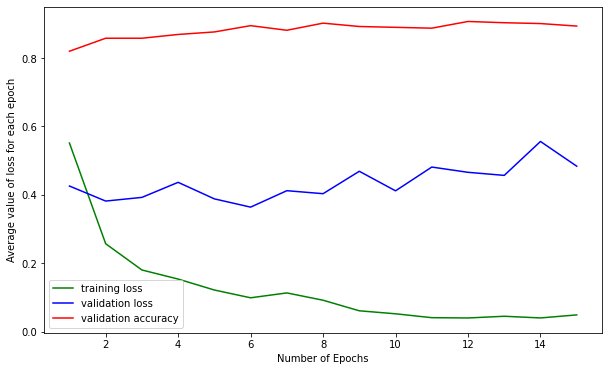

In [ ]:
class AveragePool_Model(nn.Module):
    def __init__(self):
        super(AveragePool_Model, self).__init__()
        
        self.conv1 = nn.Conv2d(in_channels = 1, out_channels = 8, kernel_size = 5)  
        self.pool = nn.MaxPool2d(2, 2)
        self.avgpool = nn.AvgPool2d(2,2)
        self.norm1 = nn.BatchNorm2d(8) 
        self.conv2 = nn.Conv2d(in_channels=8, out_channels=16,  kernel_size=5)  
        self.norm2 = nn.BatchNorm2d(16) 
        self.drop = nn.Dropout(0.5)
        self.fc1 = nn.Linear(16 * 5 * 5, 120)
        self.fc2 = nn.Linear(120, 96)
        self.fc3 = nn.Linear(96, 84)
        self.fc4 = nn.Linear(84, 3)

    def forward(self, image): 
        image = self.norm1(self.pool(F.relu(self.conv1(image)))) #6, 14, 14 
        image = self.norm2(self.avgpool(F.relu(self.conv2(image)))) #16, 5, 5
        image = image.view(-1, 16 * 5 * 5)

        image = F.relu(self.fc1(image))
        image = F.relu(self.fc2(image))
        image = F.relu(self.fc3(image))
        image = self.fc4(image)
        return image
from torch.optim import Adam
import torch.nn.functional as F
import matplotlib.pyplot as plt
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')


model = AveragePool_Model()
model.to(device)

optimizer = Adam(model.parameters())
criterion = nn.CrossEntropyLoss()
save_path = f'AveragePool_Model.pt'

TRAIN(model, train_iter, valid_iter, 15, criterion, optimizer, device,save_path)

## Average pool instead of using Max Pooling. Not record in the report. Only for testing.


Epoch [1/15], Training Loss: 0.5501, Validation Loss: 0.6690, Validation Accuracy: 0.7316
Model saved to AveragePool_Model_2.pt



Epoch [2/15], Training Loss: 0.2735, Validation Loss: 0.4397, Validation Accuracy: 0.8395
Model saved to AveragePool_Model_2.pt



Epoch [3/15], Training Loss: 0.1947, Validation Loss: 0.3956, Validation Accuracy: 0.8750
Model saved to AveragePool_Model_2.pt



Epoch [4/15], Training Loss: 0.1586, Validation Loss: 0.3920, Validation Accuracy: 0.8775
Model saved to AveragePool_Model_2.pt



Epoch [5/15], Training Loss: 0.1345, Validation Loss: 0.3988, Validation Accuracy: 0.8848
Model saved to AveragePool_Model_2.pt



Epoch [6/15], Training Loss: 0.1178, Validation Loss: 0.4325, Validation Accuracy: 0.8762



Epoch [7/15], Training Loss: 0.0845, Validation Loss: 0.4532, Validation Accuracy: 0.8676



Epoch [8/15], Training Loss: 0.0945, Validation Loss: 0.4676, Validation Accuracy: 0.8873
Model saved to AveragePool_Model_2.pt



Epoch [9/15], Training Loss: 0.0670, Validation Loss: 0.4798, Validation Accuracy: 0.8676



Epoch [10/15], Training Loss: 0.0579, Validation Loss: 0.5549, Validation Accuracy: 0.8652



Epoch [11/15], Training Loss: 0.0572, Validation Loss: 0.5060, Validation Accuracy: 0.8873



Epoch [12/15], Training Loss: 0.0529, Validation Loss: 0.5517, Validation Accuracy: 0.8848



Epoch [13/15], Training Loss: 0.0323, Validation Loss: 0.5037, Validation Accuracy: 0.8934
Model saved to AveragePool_Model_2.pt



Epoch [14/15], Training Loss: 0.0282, Validation Loss: 0.5916, Validation Accuracy: 0.8958
Model saved to AveragePool_Model_2.pt



Epoch [15/15], Training Loss: 0.0455, Validation Loss: 0.6096, Validation Accuracy: 0.8799
Finished Training
The best acuracy is: 0.8958334


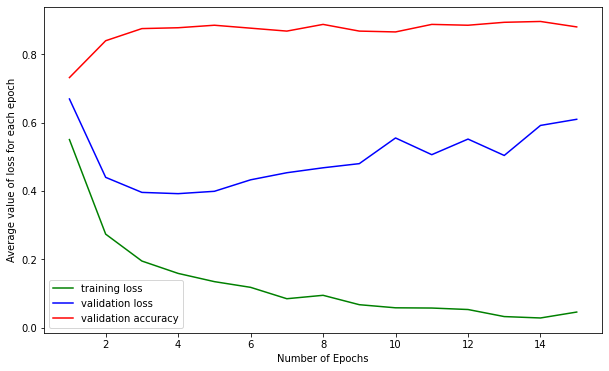

In [ ]:
class AveragePool_Model(nn.Module):
    def __init__(self):
        super(AveragePool_Model, self).__init__()
        
        self.conv1 = nn.Conv2d(in_channels = 1, out_channels = 8, kernel_size = 5)  
        self.pool = nn.MaxPool2d(2, 2)
        self.avgpool = nn.AvgPool2d(2,2)
        self.norm1 = nn.BatchNorm2d(8) 
        self.conv2 = nn.Conv2d(in_channels=8, out_channels=16,  kernel_size=5)  
        self.norm2 = nn.BatchNorm2d(16) 
        self.drop = nn.Dropout(0.5)
        self.fc1 = nn.Linear(16 * 5 * 5, 150)
        self.fc2 = nn.Linear(150, 120)
        self.fc3 = nn.Linear(120, 84)
        self.fc4 = nn.Linear(84, 3)

    def forward(self, image): 
        image = self.norm1(self.pool(F.relu(self.conv1(image)))) #6, 14, 14 
        image = self.norm2(self.avgpool(F.relu(self.conv2(image)))) #16, 5, 5
        image = image.view(-1, 16 * 5 * 5)

        image = F.relu(self.fc1(image))
        image = F.relu(self.fc2(image))
        image = F.relu(self.fc3(image))
        image = self.fc4(image)
        return image
from torch.optim import Adam
import torch.nn.functional as F
import matplotlib.pyplot as plt
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')


model = AveragePool_Model()
model.to(device)

optimizer = Adam(model.parameters())
criterion = nn.CrossEntropyLoss()
save_path = f'AveragePool_Model_2.pt'

TRAIN(model, train_iter, valid_iter, 15, criterion, optimizer, device,save_path)


Epoch [1/15], Training Loss: 0.5161, Validation Loss: 0.4115, Validation Accuracy: 0.8517
Model saved to AveragePool_Model_3.pt



Epoch [2/15], Training Loss: 0.2420, Validation Loss: 0.4729, Validation Accuracy: 0.8493



Epoch [3/15], Training Loss: 0.1665, Validation Loss: 0.4204, Validation Accuracy: 0.8762
Model saved to AveragePool_Model_3.pt



Epoch [4/15], Training Loss: 0.1432, Validation Loss: 0.4144, Validation Accuracy: 0.8836
Model saved to AveragePool_Model_3.pt



Epoch [5/15], Training Loss: 0.1132, Validation Loss: 0.4970, Validation Accuracy: 0.8750



Epoch [6/15], Training Loss: 0.0899, Validation Loss: 0.4510, Validation Accuracy: 0.8897
Model saved to AveragePool_Model_3.pt



Epoch [7/15], Training Loss: 0.0768, Validation Loss: 0.5618, Validation Accuracy: 0.8542



Epoch [8/15], Training Loss: 0.1187, Validation Loss: 0.4293, Validation Accuracy: 0.8922
Model saved to AveragePool_Model_3.pt



Epoch [9/15], Training Loss: 0.0544, Validation Loss: 0.4752, Validation Accuracy: 0.8897



Epoch [10/15], Training Loss: 0.0478, Validation Loss: 0.4696, Validation Accuracy: 0.8983
Model saved to AveragePool_Model_3.pt



Epoch [11/15], Training Loss: 0.0537, Validation Loss: 0.4726, Validation Accuracy: 0.8995
Model saved to AveragePool_Model_3.pt



Epoch [12/15], Training Loss: 0.0518, Validation Loss: 0.5286, Validation Accuracy: 0.8922



Epoch [13/15], Training Loss: 0.0329, Validation Loss: 0.5108, Validation Accuracy: 0.8971



Epoch [14/15], Training Loss: 0.0285, Validation Loss: 0.5219, Validation Accuracy: 0.9056
Model saved to AveragePool_Model_3.pt



Epoch [15/15], Training Loss: 0.0467, Validation Loss: 0.5603, Validation Accuracy: 0.8909
Finished Training
The best acuracy is: 0.90563726


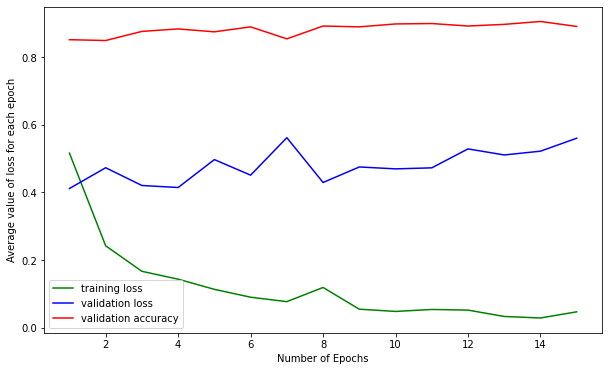

In [ ]:
# using the second model
class AveragePool_Model(nn.Module):
    def __init__(self):
        super(AveragePool_Model, self).__init__()
        
        self.conv1 = nn.Conv2d(in_channels = 1, out_channels = 8, kernel_size = 5)  
        self.pool = nn.MaxPool2d(2, 2)
        self.avgpool = nn.AvgPool2d(2,2)
        self.norm1 = nn.BatchNorm2d(8) 
        self.conv2 = nn.Conv2d(in_channels=8, out_channels=32,  kernel_size=5)  
        self.norm2 = nn.BatchNorm2d(32) 
        self.fc1 = nn.Linear(32 * 5 * 5, 150)
        self.fc2 = nn.Linear(150, 120)
        self.fc3 = nn.Linear(120, 84)
        self.fc4 = nn.Linear(84, 3)

    def forward(self, image): 
        image = self.norm1(self.pool(F.relu(self.conv1(image)))) #6, 14, 14 
        image = self.norm2(self.avgpool(F.relu(self.conv2(image)))) #16, 5, 5
        image = image.view(-1, 32 * 5 * 5)

        image = F.relu(self.fc1(image))
        image = F.relu(self.fc2(image))
        image = F.relu(self.fc3(image))
        image = self.fc4(image)
        return image
from torch.optim import Adam
import torch.nn.functional as F
import matplotlib.pyplot as plt
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')


model = AveragePool_Model()
model.to(device)

optimizer = Adam(model.parameters())
criterion = nn.CrossEntropyLoss()
save_path = f'AveragePool_Model_3.pt'

TRAIN(model, train_iter, valid_iter, 15, criterion, optimizer, device,save_path)

## Experiment 10 dropout, three cov layers and 3 fully connected layers.


Epoch [1/15], Training Loss: 0.6912, Validation Loss: 0.4587, Validation Accuracy: 0.8248
Model saved to Three_layer_model.pt



Epoch [2/15], Training Loss: 0.4590, Validation Loss: 0.4784, Validation Accuracy: 0.8199



Epoch [3/15], Training Loss: 0.3780, Validation Loss: 0.4203, Validation Accuracy: 0.8517
Model saved to Three_layer_model.pt



Epoch [4/15], Training Loss: 0.3221, Validation Loss: 0.3758, Validation Accuracy: 0.8480



Epoch [5/15], Training Loss: 0.3066, Validation Loss: 0.4268, Validation Accuracy: 0.8407



Epoch [6/15], Training Loss: 0.2657, Validation Loss: 0.3677, Validation Accuracy: 0.8566
Model saved to Three_layer_model.pt



Epoch [7/15], Training Loss: 0.2469, Validation Loss: 0.4006, Validation Accuracy: 0.8468



Epoch [8/15], Training Loss: 0.2329, Validation Loss: 0.4067, Validation Accuracy: 0.8468



Epoch [9/15], Training Loss: 0.2410, Validation Loss: 0.3668, Validation Accuracy: 0.8505



Epoch [10/15], Training Loss: 0.2154, Validation Loss: 0.3593, Validation Accuracy: 0.8627
Model saved to Three_layer_model.pt



Epoch [11/15], Training Loss: 0.1995, Validation Loss: 0.3535, Validation Accuracy: 0.8738
Model saved to Three_layer_model.pt



Epoch [12/15], Training Loss: 0.1846, Validation Loss: 0.3228, Validation Accuracy: 0.8860
Model saved to Three_layer_model.pt



Epoch [13/15], Training Loss: 0.1782, Validation Loss: 0.3630, Validation Accuracy: 0.8701



Epoch [14/15], Training Loss: 0.1825, Validation Loss: 0.3932, Validation Accuracy: 0.8591



Epoch [15/15], Training Loss: 0.1713, Validation Loss: 0.3774, Validation Accuracy: 0.8676
Finished Training
The best acuracy is: 0.8860294


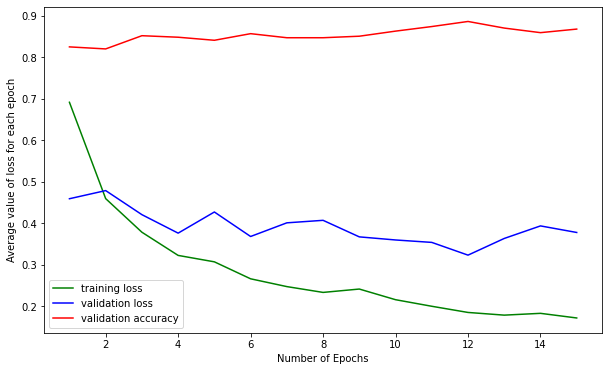

In [ ]:
class Three_layer_model(nn.Module):
    def __init__(self):
        super(Three_layer_model, self).__init__()
        
        self.conv1 = nn.Conv2d(in_channels = 1, out_channels = 8, kernel_size = 5)  #28
        self.pool = nn.MaxPool2d(2,2)#14
        self.norm1 = nn.BatchNorm2d(8) 
        self.conv2 = nn.Conv2d(in_channels=8, out_channels=16,  kernel_size=3) #12 #6
        self.norm2 = nn.BatchNorm2d(16) 
        self.conv3 = nn.Conv2d(in_channels=16, out_channels=32,  kernel_size=3)  #4 #2
        self.norm3 = nn.BatchNorm2d(32) 
        self.drop = nn.Dropout(0.5)
        self.fc1 = nn.Linear(32*2*2, 120)
        self.fc2 = nn.Linear(120, 84)
        self.fc3 = nn.Linear(84, 3)

    def forward(self, image): 
        image = self.norm1(self.pool(F.relu(self.conv1(image)))) #6, 14, 14 
        image = self.norm2(self.pool(F.relu(self.conv2(image)))) #16, 5, 5
        image = self.norm3(self.pool(F.relu(self.conv3(image))))

        image = image.view(-1, 32 * 2 * 2)
        image = self.drop(image)
        image = F.relu(self.fc1(image))
        image = F.relu(self.fc2(image))
        image = self.fc3(image)
        return image
from torch.optim import Adam
import torch.nn.functional as F
import matplotlib.pyplot as plt
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')


model = Three_layer_model()
model.to(device)

optimizer = Adam(model.parameters())
criterion = nn.CrossEntropyLoss()
save_path = f'Three_layer_model.pt'

TRAIN(model, train_iter, valid_iter, 15, criterion, optimizer, device,save_path)

## Experiment 10 with dropout three convolutional layer with four fc layers, this is not used in report. This is for testing purpose.



Epoch [1/15], Training Loss: 0.7652, Validation Loss: 0.4964, Validation Accuracy: 0.8186
Model saved to Four_linear_layer.pt



Epoch [2/15], Training Loss: 0.4997, Validation Loss: 0.4327, Validation Accuracy: 0.8199
Model saved to Four_linear_layer.pt



Epoch [3/15], Training Loss: 0.3953, Validation Loss: 0.5338, Validation Accuracy: 0.7929



Epoch [4/15], Training Loss: 0.3345, Validation Loss: 0.4964, Validation Accuracy: 0.8002



Epoch [5/15], Training Loss: 0.3083, Validation Loss: 0.4031, Validation Accuracy: 0.8407
Model saved to Four_linear_layer.pt



Epoch [6/15], Training Loss: 0.2793, Validation Loss: 0.3428, Validation Accuracy: 0.8603
Model saved to Four_linear_layer.pt



Epoch [7/15], Training Loss: 0.2538, Validation Loss: 0.3750, Validation Accuracy: 0.8529



Epoch [8/15], Training Loss: 0.2443, Validation Loss: 0.3967, Validation Accuracy: 0.8480



Epoch [9/15], Training Loss: 0.2240, Validation Loss: 0.4408, Validation Accuracy: 0.8468



Epoch [10/15], Training Loss: 0.2173, Validation Loss: 0.3296, Validation Accuracy: 0.8909
Model saved to Four_linear_layer.pt



Epoch [11/15], Training Loss: 0.2292, Validation Loss: 0.3387, Validation Accuracy: 0.8775



Epoch [12/15], Training Loss: 0.2010, Validation Loss: 0.4156, Validation Accuracy: 0.8591



Epoch [13/15], Training Loss: 0.2062, Validation Loss: 0.4110, Validation Accuracy: 0.8566



Epoch [14/15], Training Loss: 0.1932, Validation Loss: 0.4184, Validation Accuracy: 0.8444



Epoch [15/15], Training Loss: 0.1853, Validation Loss: 0.3733, Validation Accuracy: 0.8640
Finished Training
The best acuracy is: 0.8909314


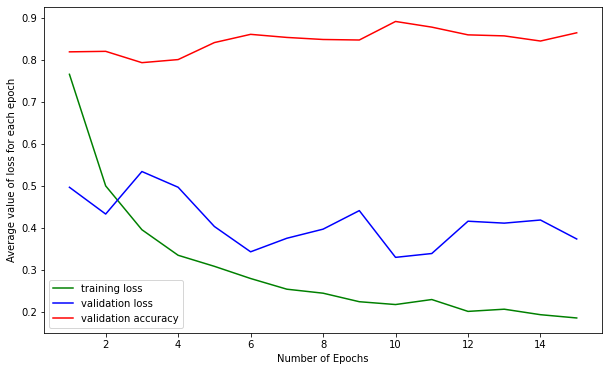

In [ ]:
# adding dropout
from torch.optim import Adam
import torch.nn.functional as F
import matplotlib.pyplot as plt
class Four_layer_model(nn.Module):
    def __init__(self):
        super(Four_layer_model, self).__init__()
        
        self.conv1 = nn.Conv2d(in_channels = 1, out_channels = 8, kernel_size = 5)  #28
        self.pool = nn.MaxPool2d(2,2)#14
        self.norm1 = nn.BatchNorm2d(8) 
        self.conv2 = nn.Conv2d(in_channels=8, out_channels=16,  kernel_size=3) #12 #6
        self.norm2 = nn.BatchNorm2d(16) 
        self.conv3 = nn.Conv2d(in_channels=16, out_channels=32,  kernel_size=3)  #4 #2
        self.norm3 = nn.BatchNorm2d(32) 
        self.drop = nn.Dropout(0.5)
        self.fc1 = nn.Linear(32*2*2, 120)
        self.fc2 = nn.Linear(120, 84)
        self.fc3 = nn.Linear(84,48)
        self.fc4 = nn.Linear(48, 3)

    def forward(self, image): 
        image = self.norm1(self.pool(F.relu(self.conv1(image)))) #6, 14, 14 
        image = self.norm2(self.pool(F.relu(self.conv2(image)))) #16, 5, 5
        image = self.norm3(self.pool(F.relu(self.conv3(image))))
        image = image.view(-1, 32 * 2 * 2)
        image = self.drop(image)
        image = F.relu(self.fc1(image))
        image = F.relu(self.fc2(image))
        image = F.relu(self.fc3(image))
        image = self.fc4(image) 
        return image

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = Four_layer_model()
model.to(device)
optimizer = Adam(model.parameters())
criterion = nn.CrossEntropyLoss()
save_path = f'Four_linear_layer.pt'

TRAIN(model, train_iter, valid_iter, 15, criterion, optimizer, device,save_path)

## Experiment 10 dropout (midified 2 ) two conv layers with 4 fc layers 


Epoch [1/15], Training Loss: 0.6637, Validation Loss: 0.5130, Validation Accuracy: 0.7929
Model saved to doubleConv_dliner_model.pt



Epoch [2/15], Training Loss: 0.4145, Validation Loss: 0.4515, Validation Accuracy: 0.8284
Model saved to doubleConv_dliner_model.pt



Epoch [3/15], Training Loss: 0.3253, Validation Loss: 0.3976, Validation Accuracy: 0.8370
Model saved to doubleConv_dliner_model.pt



Epoch [4/15], Training Loss: 0.2732, Validation Loss: 0.4822, Validation Accuracy: 0.8186



Epoch [5/15], Training Loss: 0.2386, Validation Loss: 0.3457, Validation Accuracy: 0.8787
Model saved to doubleConv_dliner_model.pt



Epoch [6/15], Training Loss: 0.2217, Validation Loss: 0.3914, Validation Accuracy: 0.8566



Epoch [7/15], Training Loss: 0.2091, Validation Loss: 0.3867, Validation Accuracy: 0.8775



Epoch [8/15], Training Loss: 0.1927, Validation Loss: 0.3697, Validation Accuracy: 0.8762



Epoch [9/15], Training Loss: 0.1861, Validation Loss: 0.4675, Validation Accuracy: 0.8333



Epoch [10/15], Training Loss: 0.1625, Validation Loss: 0.4043, Validation Accuracy: 0.8689



Epoch [11/15], Training Loss: 0.1521, Validation Loss: 0.4031, Validation Accuracy: 0.8725



Epoch [12/15], Training Loss: 0.1536, Validation Loss: 0.3948, Validation Accuracy: 0.8750



Epoch [13/15], Training Loss: 0.1482, Validation Loss: 0.4405, Validation Accuracy: 0.8824
Model saved to doubleConv_dliner_model.pt



Epoch [14/15], Training Loss: 0.1357, Validation Loss: 0.4142, Validation Accuracy: 0.8750



Epoch [15/15], Training Loss: 0.1350, Validation Loss: 0.3621, Validation Accuracy: 0.9056
Model saved to doubleConv_dliner_model.pt
Finished Training
The best acuracy is: 0.90563726


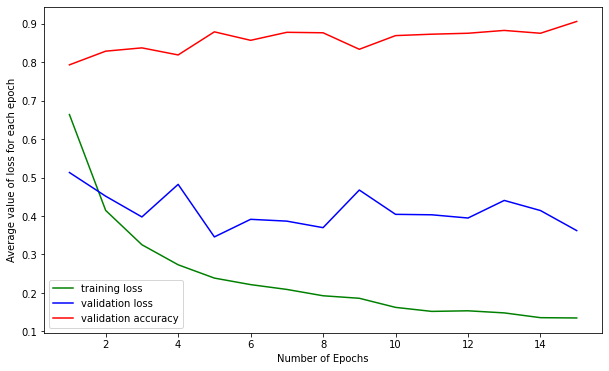

In [ ]:
# with double conv, four linear layer
# adding drop_out 
class doubleConv_dliner(nn.Module):
    def __init__(self):
        super(doubleConv_dliner, self).__init__()
        
        self.conv1 = nn.Conv2d(in_channels = 1, out_channels = 8, kernel_size = 5)  
        self.pool = nn.MaxPool2d(2, 2)
        self.norm1 = nn.BatchNorm2d(8) 
        self.conv2 = nn.Conv2d(in_channels=8, out_channels=16,  kernel_size=5)  
        self.norm2 = nn.BatchNorm2d(16) 
        self.drop = nn.Dropout(0.5)
        self.fc1 = nn.Linear(16 * 5 * 5, 120)
        self.fc2 = nn.Linear(120, 96)
        self.fc3 = nn.Linear(96, 84)
        self.fc4 = nn.Linear(84, 3)

    def forward(self, image): 
        image = self.norm1(self.pool(F.relu(self.conv1(image)))) #6, 14, 14 
        image = self.norm2(self.pool(F.relu(self.conv2(image)))) #16, 5, 5
        image = image.view(-1, 16 * 5 * 5)
        image = self.drop(image)
        image = F.relu(self.fc1(image))
        image = F.relu(self.fc2(image))
        image = F.relu(self.fc3(image))
        image = self.fc4(image)
        return image
from torch.optim import Adam
import torch.nn.functional as F
import matplotlib.pyplot as plt
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')


model = doubleConv_dliner()
model.to(device)

optimizer = Adam(model.parameters())
criterion = nn.CrossEntropyLoss()
save_path = f'doubleConv_dliner_model.pt'

TRAIN(model, train_iter, valid_iter, 15, criterion, optimizer, device,save_path)